# On the Right Track: Improving Public Transit to Build Better, More Equitable Communities through Interpretable Causal Inference
 
### Code for CISIL Causal Inference Data Challenge 
__winning entry for ASA Data Challenge 2022  Presented at CML4Impact Workshop at NeurIPS 2022__

## Imports and Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dame_flame
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
np.random.seed(42)  # Ensure reproducibility


pd.options.mode.chained_assignment = None  # Hide any pandas warnings
pd.options.display.max_columns=999 # temporarily display all columns

warnings.filterwarnings("ignore")
font = {'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)


In [2]:
# read datasets
unequal = pd.read_csv('/Users/gaurav/Developer/cisil-causal-inference/HDSR_folder/data/job_access_gap.csv') # unequal commute data
LIFT_reg = pd.read_csv('/Users/gaurav/Developer/cisil-causal-inference/HDSR_folder/data/LIFT_registry.csv') # RE-ENROLLMENT 
LIFT_boardings = pd.read_csv("/Users/gaurav/Developer/cisil-causal-inference/HDSR_folder/data/LIFT_boardings.csv") # RIDERSHIP
LIFT_boardings_update=pd.read_csv("/Users/gaurav/Developer/cisil-causal-inference/HDSR_folder/data/LIFT_boardings_2021-11-01_to_2022-03-06.csv") # RIDERSHIP


__LIFT_registry.csv__ is data obtained from King County Metro that contains all demographic information of people enrolled in the LIFT program. __LIFT_boardings.csv__ and __LIFT_boardings_update.csv__ are datasets obtined from King County Metro that contrain all boardings recorded for LIFT users. The updated dataset was released in March 2022, with more recent ridership data.
[__job_access_gap.csv__](https://datacatalog.urban.org/dataset/unequal-commute-data) is data from the [Unequal Commute Data](https://datacatalog.urban.org/dataset/unequal-commute-data) provided by the Urban Institute. It contains all unequal commute data at the census tract level.


## Preprocessing

LIFT_reg preprocessing

In [3]:
# Extract the last character from the 'card_id' column and assign it to the 'stage' column
LIFT_reg['stage'] = LIFT_reg['card_id'].str[-1:].astype(int)

# Remove the last two characters from the 'card_id' column and assign the result to the 'id' column
LIFT_reg['id'] = LIFT_reg['card_id'].str[:-2].astype(int)

# Convert the 'FIPS' column to a string and remove any trailing '.0' using regular expression replacement
LIFT_reg['FIPS'] = LIFT_reg['FIPS'].astype(str).replace('\.0', '', regex=True)

# Sort the DataFrame by the 'stage' column in descending order and keep only the first occurrence of each 'id'
LIFT_reg = LIFT_reg.sort_values('stage', ascending=False).drop_duplicates(['id'])

# Remove rows where the 'FIPS' column contains 'nan'
LIFT_reg = LIFT_reg[LIFT_reg.FIPS != 'nan']

LIFT_reg['stage'] = LIFT_reg['stage'].apply(lambda x: 0 if x == 1 else 1) 
# Given the period of data, it doesn't make sense to have a anyone re-enroll more than once since cards are valid for 12 months. 


In [4]:
LIFT_reg.head()

Age                   RaceDesc LanguageSpoken Expiration  DateIssued  \
13395   40                      Asian        English  8/31/2023  2021-09-28   
4794    41                      White        English  8/31/2023  2021-09-28   
39267   66  Black or African American        English  8/31/2024  2021-10-13   
10076   44  Black or African American        English  8/31/2023  2021-09-29   
5499    61                      White        English  8/31/2023  2021-09-28   

               CardIssuingAgency          FIPS            Initial Load  \
13395                        CCS  530330092002  Subsidized Annual Pass   
4794                         CCS  530330017012  Subsidized Annual Pass   
39267  King County Public Health  530330040001  Subsidized Annual Pass   
10076                        CCS  530330095004  Subsidized Annual Pass   
5499                         CCS  530330082001  Subsidized Annual Pass   

      Study Card  duplicate   card_id  stage      id  
13395        NaN      False   61080-8      1   61080  
4794         NaN      False   18516-6      1   18516  
39267        NaN      False  126848-6      1  126848  
10076        NaN      False   43232-6      1   43232  
5499         NaN      False   23028-6      1   23028

In [5]:
# Select the first 7 columns of the 'unequal' DataFrame and store the result in the 'unequal' DataFrame
unequal = unequal.iloc[:, :7]

# Filter the 'unequal' DataFrame to only include rows where the 'MSA' column is equal to 'Seattle'
unequal = unequal[unequal.MSA == 'Seattle']

# Convert the 'GEOID' column to a string data type
unequal['GEOID'] = unequal['GEOID'].astype(str)

unequal.head()

GEOID  OverallJobAccess  lowwagelaborforce  Access30Transit  \
0  530610518023          1.530868                413         0.063454   
1  530530634006          1.104112                186         0.015915   
2  530330219042          1.485395                174         0.080578   
3  530330219044          1.194115                200         0.067042   
4  530330219051          2.029325                283         0.086625   

   Access30Transit_ts      MSA  spatialmismatch  
0            0.030801  Seattle         0.073675  
1            0.000264  Seattle         0.039919  
2            0.075943  Seattle         0.031712  
3            0.075943  Seattle         0.041396  
4            0.060658  Seattle         0.038509

We merge _unequal_ with _LIFT_reg_ on the census tract of the resident. The assumption is that the person living in a given tract faces the same unequal commute conditions representative of the tract.

In [6]:
# Merge the 'LIFT_reg' and 'unequal' DataFrames based on the 'FIPS' column in 'LIFT_reg' and the 'GEOID' column in 'unequal'
# An inner join is used to keep only the matching rows from both DataFrames
merged = LIFT_reg.merge(unequal, left_on='FIPS', right_on='GEOID', how='inner')

In [7]:
# List of columns for which quantiles will be calculated
cols = ['OverallJobAccess', 'lowwagelaborforce', 'Access30Transit', 'Access30Transit_ts', 'spatialmismatch']

# Calculate quartiles (4 quantiles) for each specified column and create new columns with quantile labels
for col in cols:
    merged[col + '_quantile_4q'] = pd.qcut(merged[col], q=4)
    merged[col + '_quantileNum_4q'] = pd.qcut(merged[col], q=4, labels=False)

merged.head()

Age                   RaceDesc LanguageSpoken Expiration  DateIssued  \
0   40                      Asian        English  8/31/2023  2021-09-28   
1   51  Black or African American        English  8/31/2023  2021-10-19   
2   42  Black or African American        English  4/30/2023  2021-04-29   
3   59  Black or African American        English  8/31/2023  2021-11-23   
4   44         Hispanic or Latino        English  8/31/2023  2021-11-10   

                CardIssuingAgency          FIPS            Initial Load  \
0                             CCS  530330092002  Subsidized Annual Pass   
1                             CCS  530330092002  Subsidized Annual Pass   
2  HS Jail Health Services BA6586  530330092002                     NaN   
3       King County Public Health  530330092002  Subsidized Annual Pass   
4                             CCS  530330092002  Subsidized Annual Pass   

  Study Card  duplicate   card_id  stage      id         GEOID  \
0        NaN      False   61080-8      1   61080  530330092002   
1        NaN      False  107444-6      1  107444  530330092002   
2        NaN      False   57528-6      1   57528  530330092002   
3        NaN      False   10168-5      1   10168  530330092002   
4        NaN      False  172698-5      1  172698  530330092002   

   OverallJobAccess  lowwagelaborforce  Access30Transit  Access30Transit_ts  \
0          2.245899                708         1.487184            0.721379   
1          2.245899                708         1.487184            0.721379   
2          2.245899                708         1.487184            0.721379   
3          2.245899                708         1.487184            0.721379   
4          2.245899                708         1.487184            0.721379   

       MSA  spatialmismatch OverallJobAccess_quantile_4q  \
0  Seattle         0.083322                (1.81, 3.632]   
1  Seattle         0.083322                (1.81, 3.632]   
2  Seattle         0.083322                (1.81, 3.632]   
3  Seattle         0.083322                (1.81, 3.632]   
4  Seattle         0.083322                (1.81, 3.632]   

   OverallJobAccess_quantileNum_4q lowwagelaborforce_quantile_4q  \
0                                3               (504.0, 1252.0]   
1                                3               (504.0, 1252.0]   
2                                3               (504.0, 1252.0]   
3                                3               (504.0, 1252.0]   
4                                3               (504.0, 1252.0]   

   lowwagelaborforce_quantileNum_4q Access30Transit_quantile_4q  \
0                                 3              (0.436, 3.047]   
1                                 3              (0.436, 3.047]   
2                                 3              (0.436, 3.047]   
3                                 3              (0.436, 3.047]   
4                                 3              (0.436, 3.047]   

   Access30Transit_quantileNum_4q Access30Transit_ts_quantile_4q  \
0                               3                 (0.258, 3.047]   
1                               3                 (0.258, 3.047]   
2                               3                 (0.258, 3.047]   
3                               3                 (0.258, 3.047]   
4                               3                 (0.258, 3.047]   

   Access30Transit_ts_quantileNum_4q spatialmismatch_quantile_4q  \
0                                  3            (0.0765, 0.0994]   
1                                  3            (0.0765, 0.0994]   
2                                  3            (0.0765, 0.0994]   
3                                  3            (0.0765, 0.0994]   
4                                  3            (0.0765, 0.0994]   

   spatialmismatch_quantileNum_4q  
0                               2  
1                               2  
2                               2  
3                               2  
4                               2

In [8]:
for col in cols: 
    print(col, merged[col + '_quantile_4q'].unique())

OverallJobAccess [(1.81, 3.632], (1.26, 1.81], (0.0635, 0.81], (0.81, 1.26]]
Categories (4, interval[float64, right]): [(0.0635, 0.81] < (0.81, 1.26] < (1.26, 1.81] < (1.81, 3.632]]
lowwagelaborforce [(504.0, 1252.0], (1.999, 297.0], (297.0, 385.0], (385.0, 504.0]]
Categories (4, interval[float64, right]): [(1.999, 297.0] < (297.0, 385.0] < (385.0, 504.0] < (504.0, 1252.0]]
Access30Transit [(0.436, 3.047], (0.0919, 0.436], (0.0312, 0.0919], (-0.001, 0.0312]]
Categories (4, interval[float64, right]): [(-0.001, 0.0312] < (0.0312, 0.0919] < (0.0919, 0.436] < (0.436, 3.047]]
Access30Transit_ts [(0.258, 3.047], (0.0654, 0.258], (-0.001, 0.00981], (0.00981, 0.0654]]
Categories (4, interval[float64, right]): [(-0.001, 0.00981] < (0.00981, 0.0654] < (0.0654, 0.258] < (0.258, 3.047]]
spatialmismatch [(0.0765, 0.0994], (-0.001, 0.0564], (0.0564, 0.0765], (0.0994, 0.365]]
Categories (4, interval[float64, right]): [(-0.001, 0.0564] < (0.0564, 0.0765] < (0.0765, 0.0994] < (0.0994, 0.365]]


There are 98228 people in the lift registry, 94133 people in the lift registry with a FIPS code, 93660 people with a FIPS in the unequal commute dataset.

In [9]:
merged.columns = [c.replace(' ', '_') for c in merged.columns]
merged['DateIssued'] = pd.to_datetime(merged['DateIssued'])

# After filtering for dates after 2020-10-01 , this is the date after treatment was ended. Treatment is distribution of SAP cards.
sap = merged[(merged.DateIssued >= "2020-10-01")]

sap["SAP"] = np.where(sap["Initial_Load"] == "Subsidized Annual Pass", 1, 0)
top5 = sap.value_counts("CardIssuingAgency").index[:5]
top5.tolist()
sap['Agency'] = (sap.CardIssuingAgency.
                          apply(lambda x: x 
                                if x in top5 
                                else "Other"))
top5 = sap.value_counts("LanguageSpoken").index[:5]
top5.tolist()
sap['Language'] = (sap.LanguageSpoken.
                          apply(lambda x: x 
                                if x in top5 
                                else "Other"))
# split into user id and card number
sap[['user_id', 'stage']] = sap['card_id'].str.split('-', expand=True)
# bin age.
sap['Age_bin']=pd.cut(x = sap['Age'],
                        bins = [0,25,35,45,55,65,200], 
                        labels = [0,1,2,3,4,5])

# Create the feature 'count_enroll' to count the number of enrollments per user_id.
sap["stage"] = merged["stage"]
sap['count_enroll'] = sap['stage']

In [10]:
sap["SAP"].value_counts()

0    17900
1     8173
Name: SAP, dtype: int64

In [11]:


# sap = sap.loc[:, ~sap.columns.isin(['Study_Card', 'card_id','DateIssued','GEOID','Unnamed:_0','Expiration','LanguageSpoken','Age','CardIssuingAgency'])]

sap_enrollment = sap
sap_enrollment = sap.loc[:, ~sap.columns.isin(['stage'])]
sap_enrollment['count_enroll'] = sap_enrollment['count_enroll'].astype(int)
ds_general = sap_enrollment.loc[:, ~sap_enrollment.columns.isin(['FIPS','Age','DateIssued','Expiration', 'duplicate'])]
ds_general = ds_general.drop_duplicates()

# 1 value in Age_bin was NA.
ds_general = ds_general[ds_general['Age_bin'].notna()]
ds_general

# Fill in the NA race values, labeling as "Other"
ds_general["RaceDesc"] = ds_general["RaceDesc"].fillna(value="Other")
ds_general["Initial_Load"] = ds_general["Initial_Load"].fillna(value="NA")

match_all = ds_general.loc[:, ~ds_general.columns.isin(['user_id','Age'])]
match_all

# Map all string categorical variables to numbers.
race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 4, 'American Indian or Alaska Native': 4, "Multi-Racial": 4, "Native Hawaiian or Other Pacific Islander": 4}
match_all['RaceDesc'] = match_all['RaceDesc'].map(race)

language = {"English": 0, "Chinese": 1, "Spanish": 2, "Dari": 3, "Vietnamese": 4, 'Other': 5}
match_all['Language'] = match_all['Language'].map(language)

a = {"King County Public Health": 0, "DSHS - ORCA LIFT (remote enrollment)": 1, "DSHS - subsidized annual pass (remote enrollment)": 2, "CCS": 3, "KCMCCS": 4, 'Other': 5}
match_all['Agency'] = match_all['Agency'].map(a)

a = {"10": 0, "Subsidized Annual Pass": 1, "NA": 2, "70": 3, "20": 4, '50': 5,  '15': 6, 'Misc. Pass':7, '30': 8, 'Passport': 9 }
match_all['Initial_Load'] = match_all['Initial_Load'].map(a)


In [12]:
match_all = match_all.loc[:, ~match_all.columns.isin(['Unnamed: 0'])]
match_all

RaceDesc LanguageSpoken                     CardIssuingAgency  \
0             2        English                                   CCS   
1             1        English                                   CCS   
2             1        English        HS Jail Health Services BA6586   
3             1        English             King County Public Health   
4             3        English                                   CCS   
...         ...            ...                                   ...   
93559         1        English             King County Public Health   
93563         0        English                                KCMCCS   
93572         0        English  DSHS - ORCA LIFT (remote enrollment)   
93598         0        English                                   CCS   
93639         1        English  DSHS - ORCA LIFT (remote enrollment)   

       Initial_Load Study_Card   card_id      id         GEOID  \
0                 1        NaN   61080-8   61080  530330092002   
1                 1        NaN  107444-6  107444  530330092002   
2                 2        NaN   57528-6   57528  530330092002   
3                 1        NaN   10168-5   10168  530330092002   
4                 1        NaN  172698-5  172698  530330092002   
...             ...        ...       ...     ...           ...   
93559             2        NaN  237038-1  237038  530330220034   
93563             0        NaN  237256-1  237256  530610526071   
93572             0        NaN  236550-1  236550  530530730053   
93598             0        NaN   39120-1   39120  530330321021   
93639             0        NaN   14204-1   14204  530530723102   

       OverallJobAccess  lowwagelaborforce  Access30Transit  \
0              2.245899                708         1.487184   
1              2.245899                708         1.487184   
2              2.245899                708         1.487184   
3              2.245899                708         1.487184   
4              2.245899                708         1.487184   
...                 ...                ...              ...   
93559          1.456875                174         0.017855   
93563          0.472162                493         0.001867   
93572          0.229570                231         0.004476   
93598          0.400939                239         0.005537   
93639          0.656824                208         0.114384   

       Access30Transit_ts      MSA  spatialmismatch  \
0                0.721379  Seattle         0.083322   
1                0.721379  Seattle         0.083322   
2                0.721379  Seattle         0.083322   
3                0.721379  Seattle         0.083322   
4                0.721379  Seattle         0.083322   
...                   ...      ...              ...   
93559            0.000024  Seattle         0.032133   
93563            0.001867  Seattle         0.132258   
93572            0.004476  Seattle         0.066728   
93598            0.005537  Seattle         0.065562   
93639            0.030869  Seattle         0.052540   

      OverallJobAccess_quantile_4q  OverallJobAccess_quantileNum_4q  \
0                    (1.81, 3.632]                                3   
1                    (1.81, 3.632]                                3   
2                    (1.81, 3.632]                                3   
3                    (1.81, 3.632]                                3   
4                    (1.81, 3.632]                                3   
...                            ...                              ...   
93559                 (1.26, 1.81]                                2   
93563               (0.0635, 0.81]                                0   
93572               (0.0635, 0.81]                                0   
93598               (0.0635, 0.81]                                0   
93639               (0.0635, 0.81]                                0   

      lowwagelaborforce_quantile_4q  lowwagelaborforce_quantileNum_4q  \
0    

## Re-enrollment 

In [13]:

# Specify the columns to select
select_columns = ['RaceDesc', 'SAP', 'count_enroll', 'OverallJobAccess_quantileNum_4q', 'lowwagelaborforce_quantileNum_4q', 'Access30Transit_quantileNum_4q', 'Access30Transit_ts_quantileNum_4q', 'spatialmismatch_quantileNum_4q', 'Agency', 'Language', 'Age_bin']

# Select the specified columns from the DataFrame
match_all_reenrollment = match_all[select_columns]


In [14]:
match_all_reenrollment.head()

RaceDesc  SAP  count_enroll  OverallJobAccess_quantileNum_4q  \
0         2    1             1                                3   
1         1    1             1                                3   
2         1    0             1                                3   
3         1    1             1                                3   
4         3    1             1                                3   

   lowwagelaborforce_quantileNum_4q  Access30Transit_quantileNum_4q  \
0                                 3                               3   
1                                 3                               3   
2                                 3                               3   
3                                 3                               3   
4                                 3                               3   

   Access30Transit_ts_quantileNum_4q  spatialmismatch_quantileNum_4q  Agency  \
0                                  3                               2       3   
1                                  3                               2       3   
2                                  3                               2       5   
3                                  3                               2       0   
4                                  3                               2       3   

   Language Age_bin  
0         0       2  
1         0       3  
2         0       2  
3         0       4  
4         0       2

In [15]:
# flame is faster but dame considers more covariate sets. stopping upon matching all t'ed units.
model_flame_reenrollment = dame_flame.matching.FLAME(repeats=False, verbose=3, 
                                            early_stop_iterations=30, 
                                            stop_unmatched_t = True, 
                                            adaptive_weights='ridge',
                                            alpha=0.5, want_pe=True)

In [16]:
model_flame_reenrollment.fit(holdout_data=False, treatment_column_name='SAP', outcome_column_name='count_enroll')
result_flame_AMT = model_flame_reenrollment.predict(match_all_reenrollment)

Iteration number:  1
	Number of matched groups formed in total:  1118
	Unmatched treated units:  4959 out of a total of  8173 treated units
	Unmatched control units:  13350 out of a total of  17899 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  7763
	Number of matches made so far:  7763
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  2451
	Unmatched treated units:  1792 out of a total of  8173 treated units
	Unmatched control units:  7880 out of a total of  17899 control units
	Predictive error of covariates chosen this iteration:  0.44908356453253306
	Number of matches made in this iteration:  8637
	Number of matches made so far:  16400
	In this iteration, the covariates dropped are:  Agency
Iteration number:  3
	Number of matched groups formed in total:  3019
	Unmatched treated units:  509 out of a total of  8173 treated units
	Unmatched control

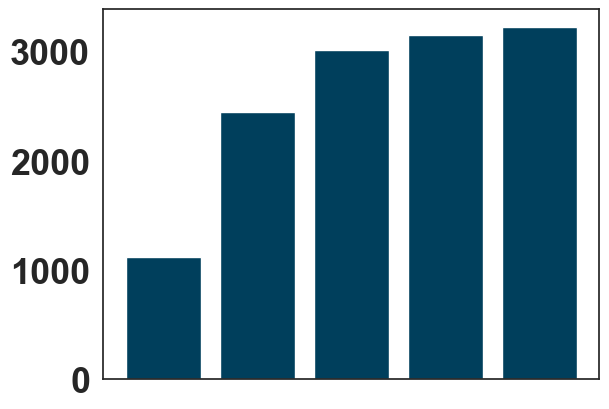

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the iterations
iteration_numbers = [1, 2, 3, 4, 5]
matched_groups = [1118, 2451, 3019, 3154, 3228]

# Creating the bar chart with dark blue color and removing unnecessary labels
plt.bar(iteration_numbers, matched_groups, color='#003F5C', width=0.8)  # Adjust the width as needed

# Remove x-axis labels and ticks
plt.xticks([])

# Add y-ticks for every 1000
plt.yticks(np.arange(0, max(matched_groups) + 1, 1000), fontsize=26)

plt.show()


In [17]:
result_flame_AMT

RaceDesc OverallJobAccess_quantileNum_4q  \
0            2                               3   
1            1                               3   
2            1                               3   
3            1                               3   
4            3                               3   
...        ...                             ...   
93559        1                               2   
93563        0                               0   
93572        0                               0   
93598        0                               0   
93639        1                               0   

      lowwagelaborforce_quantileNum_4q Access30Transit_quantileNum_4q  \
0                                    3                              3   
1                                    3                              3   
2                                    3                              3   
3                                    3                              3   
4                                    3                              3   
...                                ...                            ...   
93559                                0                              0   
93563                                2                              0   
93572                                0                              0   
93598                                0                              0   
93639                                0                              2   

      Access30Transit_ts_quantileNum_4q spatialmismatch_quantileNum_4q Agency  \
0                                     3                              2      *   
1                                     3                              2      3   
2                                     3                              2      *   
3                                     3                              2      0   
4                                     3                              2      3   
...                                 ...                            ...    ...   
93559                                 0                              0      *   
93563                                 0                              3      *   
93572                                 0                              1      *   
93598                                 0                              1      3   
93639                                 1                              0      *   

      Language Age_bin  
0            0       2  
1            0       3  
2            0       *  
3            0       4  
4            0       2  
...        ...     ...  
93559        0       *  
93563        0       2  
93572        0       4  
93598        0       3  
93639        0       *  

[23197 rows x 9 columns]

Create Figure Displaying Match Group Size vs. Covariates Matched.

In [18]:
# ATE Overall.
ate_AMT = dame_flame.utils.post_processing.ATE(model_flame_reenrollment)

print("The overall average treatment effect of re-enrollment is",ate_AMT)

The overall average treatment effect of re-enrollment is 0.1123420291885369


As we can see, the ATE is slightly positive, implying that the subsidized annual pass (SAP) causes an enroller to enroll more than non-SAP recipients by this many more times.

### Exploring Match groups to illustrate interpretability of our approach.
Our entire data pipeline is interpretable and matched groups that can be manually checked for trustworthiness, allowing us to form reliable conclusions. 

In [19]:
group1 = model_flame_reenrollment.units_per_group[10]
s_mmg = match_all_reenrollment.loc[group1]
s_mmg # each row of group 1.

RaceDesc  SAP  count_enroll  OverallJobAccess_quantileNum_4q  \
42259         0    1             1                                1   
42272         0    0             0                                1   
73891         0    0             0                                1   

       lowwagelaborforce_quantileNum_4q  Access30Transit_quantileNum_4q  \
42259                                 0                               2   
42272                                 0                               2   
73891                                 0                               2   

       Access30Transit_ts_quantileNum_4q  spatialmismatch_quantileNum_4q  \
42259                                  3                               1   
42272                                  3                               1   
73891                                  3                               1   

       Agency  Language Age_bin  
42259       0         0       0  
42272       0         0       0  
73891       0         0       0

### Helper functions to plot Conditional Average Treatment Effects 
(to see subgroup effects)

In [20]:
def create_df_scatter(feature, category, model, dataframe):
    '''
    Creates a scatter plot of the size of matched group against CATE estimate.
    Note: the model name and dataframe are specified below 
    (make sure to change for different models and dataframe).
    
    feature (str): variable of interest.
    category (int): level of variable to highlight.
    '''
    group_size_overall = []
    cate_of_group = []
    in_desired_variable = []
    size_desired_group = []
    cate_desired_group = []
    

    for group in model.units_per_group:

        # find len of just treated units
        df_mmg = dataframe.loc[group] # chooses rows with row id in group.
        treated = df_mmg.loc[df_mmg["SAP"] == 1] # chooses the rows with treatment = 1
        desired_variable = df_mmg.iloc[0][feature] == category # true/false vector. an indicator.

        # group_size_treated.append(len(treated))
        group_size_overall.append(len(group))
        in_desired_variable.append(desired_variable)

        cate_of_group.append(dame_flame.utils.post_processing.CATE(model, group[0]))
        
        if desired_variable == True:
            cate_desired_group.append(dame_flame.utils.post_processing.CATE(model, group[0]))
            size_desired_group.append(len(group))
        
    
    return(group_size_overall, cate_of_group, in_desired_variable, size_desired_group, cate_desired_group)


In [21]:
def create_cate_lst(sizes, cates):
    '''
    helper function to create credible interval for ATE. Creates an extended list
    where each element is the CATE for a unit.'''
    
    out = []
    for i in range(len(cates)):
        for j in range(sizes[i]):
            out.append(cates[i])
    return out 

### Generate Re-enrollment Plots: Create Scatter Plots Displaying CATES of re-enrollment

In [22]:
# Calculate the quantiles for ATE.
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2, model_flame_reenrollment, match_all_reenrollment)

cate_lst = create_cate_lst(size, cate_all)

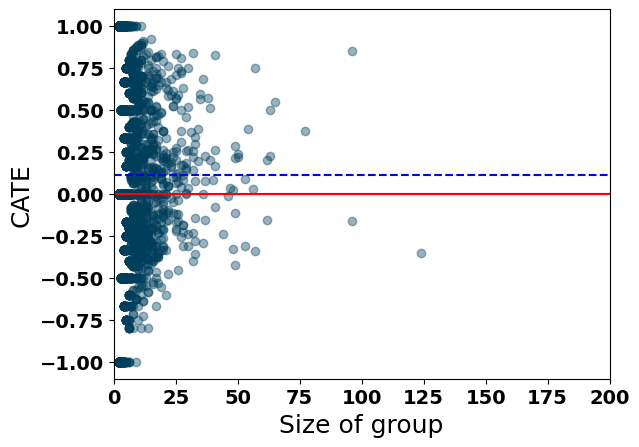

In [23]:
plt.scatter(size, cate_all, c = "#003f5c", alpha=0.4)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=ate_AMT, color='b', linestyle='--')
plt.xlim(0,200)
plt.tick_params( labelsize=14)
# plt.xlabel('Size of group')
# plt.ylabel('Estimated Treatment Effect of Group')
# plt.title("Visualizing Enrollment CATE of matched groups by size", fontsize=14)

plt.xlabel('Size of group',fontsize=18)
plt.ylabel('CATE',fontsize=18)

plt.savefig('figs/reenrollment/ate_scatter_enrollment.pdf', bbox_inches="tight", dpi=300)

In [24]:
# Here are the corresponding codes for race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2, model_flame_reenrollment, match_all_reenrollment)

### Scatterplot for Asian Enrollment

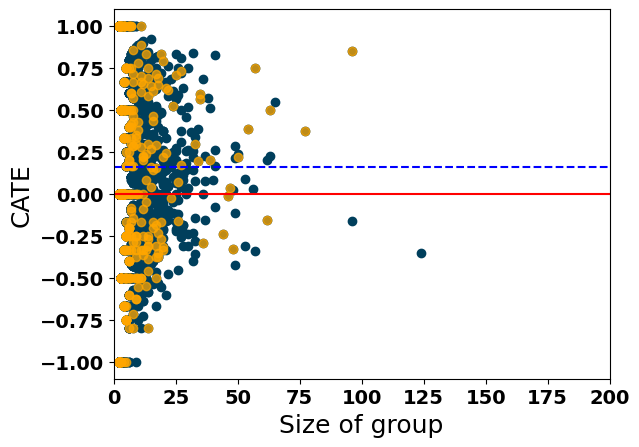

In [25]:
# Scatterplot Displaying the CATE of matched groups with Asian Individuals
cate_lst = create_cate_lst(size_asian, cate_asian)

mean_cate = sum(cate_lst)/len(cate_lst)
mean_cate
cors = {True:'#bc5090', False:'#ffa600'}
asian = pd.Series(in_asian)

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_asian, cate_asian, c = "#ffa600", alpha=.75)
plt.tick_params( labelsize=14)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=mean_cate, color='blue', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group',fontsize=18)
plt.ylabel('CATE',fontsize=18)

plt.savefig('figs/reenrollment/asian_enroll.pdf', bbox_inches="tight", dpi=300)

### Scatterplot for AccesstoTransit

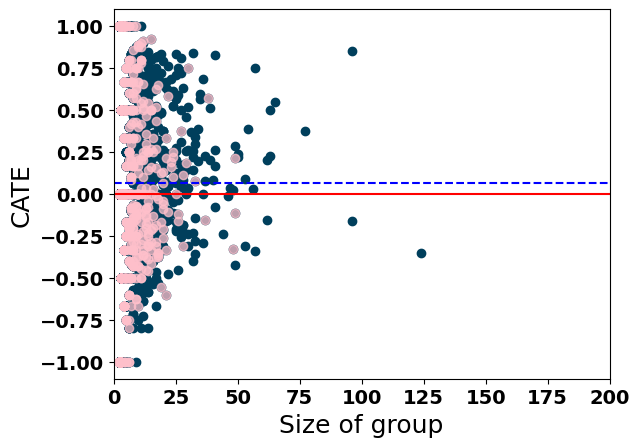

In [26]:
# Scatterplot Displaying the CATE of matched groups with transit1 individuals.
# Calculate the quantiles for Lowest transit Quantile.
(size, cate_all, in_trans1, size_trans1, cate_trans1) = create_df_scatter("Access30Transit_quantileNum_4q", 0, model_flame_reenrollment, match_all_reenrollment)

cate_lst = create_cate_lst(size_trans1, cate_trans1)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_trans1, cate_trans1, c = "pink", alpha=.75)
plt.tick_params( labelsize=14)
plt.axhline(y=0.0, color='red', linestyle='-')
plt.axhline(y=mean_cate, color='blue', linestyle='--')
# plt.axhline(y=lb, color='red', linestyle='--')
# plt.axhline(y=ub, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.savefig('figs/reenrollment/trans1_enroll.pdf', bbox_inches="tight", dpi=300)

In [27]:
# Calculate the quantiles for Highest transit quantile.
(size, cate_all, in_trans3, size_trans3, cate_trans3) = create_df_scatter("Access30Transit_quantileNum_4q", 3, model_flame_reenrollment, match_all_reenrollment)

cate_lst = create_cate_lst(size_trans3, cate_trans3)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)


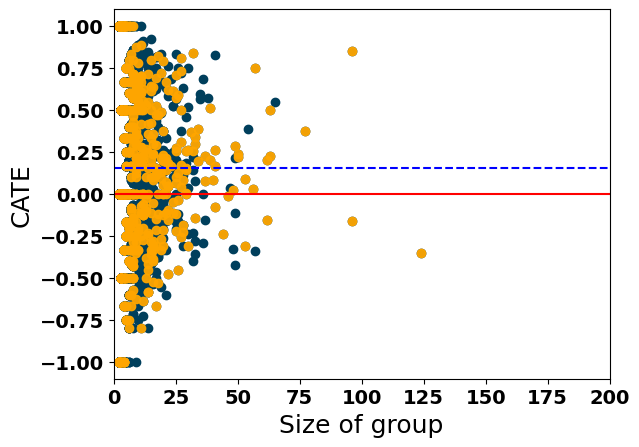

In [28]:
# Scatterplot Displaying the CATE of matched groups with transit3 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_trans3, cate_trans3, c = "#ffa600", alpha=0.95)

plt.axhline(y=0.0, color='red', linestyle='-')
plt.axhline(y=mean_cate, color='blue', linestyle='--')
plt.xlim(0,200)
plt.tick_params( labelsize=14)
plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)

plt.savefig('figs/reenrollment/trans3_enroll.pdf', bbox_inches="tight", dpi=300)

In [29]:
# For each unit, we can see a table displaying the covariates it was matched on.
matched = model_flame_reenrollment.df_units_and_covars_matched
matched[:10]

RaceDesc OverallJobAccess_quantileNum_4q lowwagelaborforce_quantileNum_4q  \
0         2                               3                                3   
1         1                               3                                3   
2         1                               3                                3   
3         1                               3                                3   
4         3                               3                                3   
5         1                               3                                3   
7         0                               3                                3   
8         1                               3                                3   
9         1                               3                                3   
10        0                               3                                3   

   Access30Transit_quantileNum_4q Access30Transit_ts_quantileNum_4q  \
0                               3                                 3   
1                               3                                 3   
2                               3                                 3   
3                               3                                 3   
4                               3                                 3   
5                               3                                 3   
7                               3                                 3   
8                               3                                 3   
9                               3                                 3   
10                              3                                 3   

   spatialmismatch_quantileNum_4q Agency Language Age_bin  
0                               2      *        0       2  
1                               2      3        0       3  
2                               2      *        0       *  
3                               2      0        0       4  
4                               2      3        0       2  
5                               2      0        0       3  
7                               2      3        0       4  
8                               2      0        0       0  
9                               2      *        0       3  
10                              2      0        0       4

### Scatterplot for OverallJobAccess

In [30]:
# Calculate the quantiles for Lowest Overall Job Access Quantile.
(size, cate_all, in_Ja1, size_Ja1, cate_Ja1) = create_df_scatter("OverallJobAccess_quantileNum_4q", 0, model_flame_reenrollment, match_all_reenrollment)

cate_lst = create_cate_lst(size_Ja1, cate_Ja1)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub) 

0.04646133791837441 0.05892009119830026 0.07137884447822611


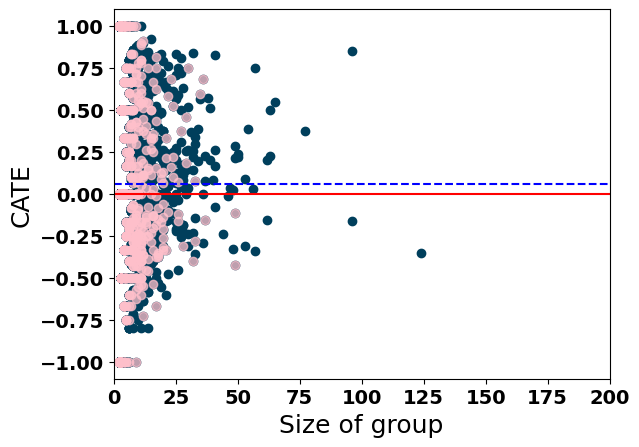

In [31]:
# Scatterplot Displaying the CATE of matched groups with Ja1 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_Ja1, cate_Ja1, c = "pink", alpha=.75)

plt.axhline(y=0.0, color='red', linestyle='-')
# plt.axhline(y=lb, color='red', linestyle='--')
# plt.axhline(y=ub, color='red', linestyle='--')
plt.axhline(y=mean_cate, color='blue', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.tick_params( labelsize=14)

plt.savefig('figs/reenrollment/job_access.pdf', bbox_inches="tight", dpi=300)

In [32]:
# Calculate the quantiles for Highest Overall Job Access Quantile.
(size, cate_all, in_Ja3, size_Ja3, cate_Ja3) = create_df_scatter("OverallJobAccess_quantileNum_4q", 3, model_flame_reenrollment, match_all_reenrollment)

cate_lst = create_cate_lst(size_Ja3, cate_Ja3)

## Conf. Interval
mean_cate = sum(cate_lst)/len(cate_lst)

# normal approximation
lb = mean_cate - 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
ub = mean_cate + 1.96*(np.std(cate_lst) / np.sqrt(len(cate_lst)))
print(lb, mean_cate, ub) 

0.1370236833695787 0.14656076810917118 0.15609785284876365


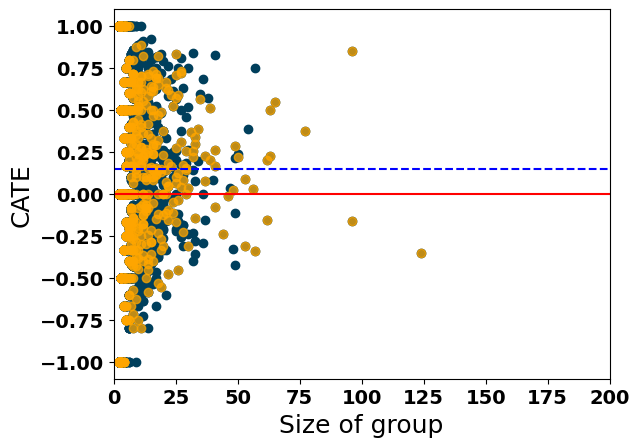

In [33]:
# Scatterplot Displaying the CATE of matched groups with Ja1 individuals.
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_Ja3, cate_Ja3, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='red', linestyle='-')
# plt.axhline(y=lb, color='red', linestyle='--')
# plt.axhline(y=ub, color='red', linestyle='--')
plt.axhline(y=mean_cate, color='blue', linestyle='--')
plt.xlim(0,200)
plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.tick_params( labelsize=14)

plt.savefig('figs/reenrollment/job_access.pdf', bbox_inches="tight", dpi=300)

In [34]:
def get_cates_and_counts(df, column_name: str,model) -> pd.DataFrame:
    """
    Return pd DataFrame with CATE values and Count Values to plot both
    
    - 'CATE' column has CATE value corresponding to all the units with that value in the column
    - 'Counts' column has the number of all units in the data that are matched to a group that 
    has that specific value, i.e. 1791 individuals/units with matched in a group such that race=White
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the data.
    - column_name (str): The column for which CATE values and counts need to be calculated.

    Returns:
    - pd.DataFrame: DataFrame with 'CATE' and 'Counts' columns.
    """

    # Initialize dictionaries to store CATE values and counts
    cate_unit_count = {}
    cates = {}  # {asian: [0.1, 0.3, ..], black: [0.1, 0.3, ..], ...}
    cates_avg = {}  # {asian: 4, black: 5, ...}
    
    # Loop over unique values in the specified column
    for val in set(df[column_name].tolist()):
        cates[val] = []
        
        # Loop over indices where the column has the specified value
        for i in df[(df[column_name] == val)].index:
            # Calculate CATE for each unit with the specified value in the column
            unit_cate = dame_flame.utils.post_processing.CATE(model, i)
            
            # Check if CATE is not NaN
            if not math.isnan(unit_cate):
                cates[val].append(unit_cate)
                
                # Update the count of units for the current value
                if val not in cate_unit_count:
                    cate_unit_count[val] = 0
                cate_unit_count[val] += 1
        
        # Calculate average CATE for the current value
        if len(cates[val]) > 0:
            cates_avg[val] = sum(cates[val]) / len(cates[val])

    # Convert dictionaries to pandas Series
    cates_avg_series = pd.Series(cates_avg)
    cate_unit_count_series = pd.Series(cate_unit_count)
    
    # Get the number of occurrences of each value in the column
    num_lvls = df[column_name].value_counts()
    num_lvls = num_lvls.reset_index(drop=True)
    
    # Create a DataFrame with 'CATE' and 'Counts' columns
    frame = {'CATE': cates_avg_series, 
             'Counts': num_lvls,
             'num_units_used': cate_unit_count_series}
    data = pd.DataFrame(frame)
    
    # Convert index to strings and sort the DataFrame
    data.index = data.index.map(str)
    # data = data.sort_index() 
    
    return data


In [35]:
cols = ['RaceDesc','OverallJobAccess_quantileNum_4q','lowwagelaborforce_quantileNum_4q',
        'Access30Transit_quantileNum_4q','Access30Transit_ts_quantileNum_4q','spatialmismatch_quantileNum_4q',
        'Agency','Language','Age_bin']

def export_cate_df(cols: list, input_df=match_all_reenrollment, model=model_flame_reenrollment): 
        """
        Create dictionary where
        - keys are column (i.e. White)
        - values are pandas dataframe (i.e. pandas dataframe created using get_cates_and_counts() that shows CATE
        values and counts)
        """
        df={}
        for col in cols:
                df[col] = get_cates_and_counts(input_df, col, model)
        return df

df_dic = export_cate_df(cols, match_all_reenrollment, model_flame_reenrollment)

Unit 5276 does not have any matches, so can't find the CATE
Unit 9990 does not have any matches, so can't find the CATE
Unit 11598 does not have any matches, so can't find the CATE
Unit 12194 does not have any matches, so can't find the CATE
Unit 12812 does not have any matches, so can't find the CATE
Unit 12813 does not have any matches, so can't find the CATE
Unit 12814 does not have any matches, so can't find the CATE
Unit 13402 does not have any matches, so can't find the CATE
Unit 16421 does not have any matches, so can't find the CATE
Unit 17328 does not have any matches, so can't find the CATE
Unit 17513 does not have any matches, so can't find the CATE
Unit 17517 does not have any matches, so can't find the CATE
Unit 17529 does not have any matches, so can't find the CATE
Unit 17530 does not have any matches, so can't find the CATE
Unit 18816 does not have any matches, so can't find the CATE
Unit 18992 does not have any matches, so can't find the CATE
Unit 18996 does not have a

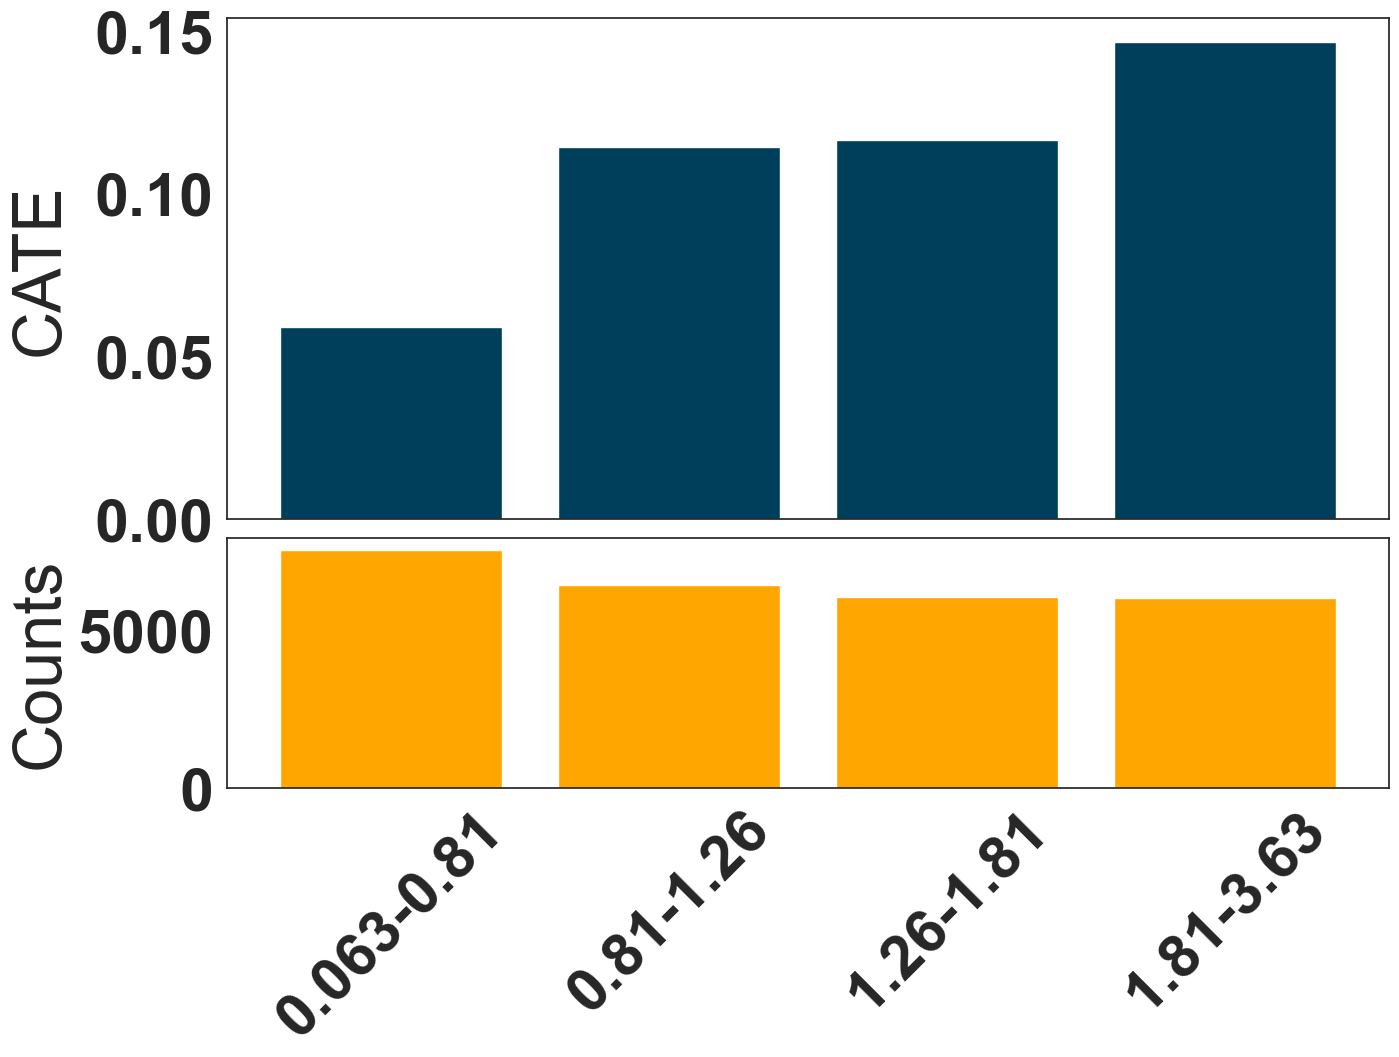

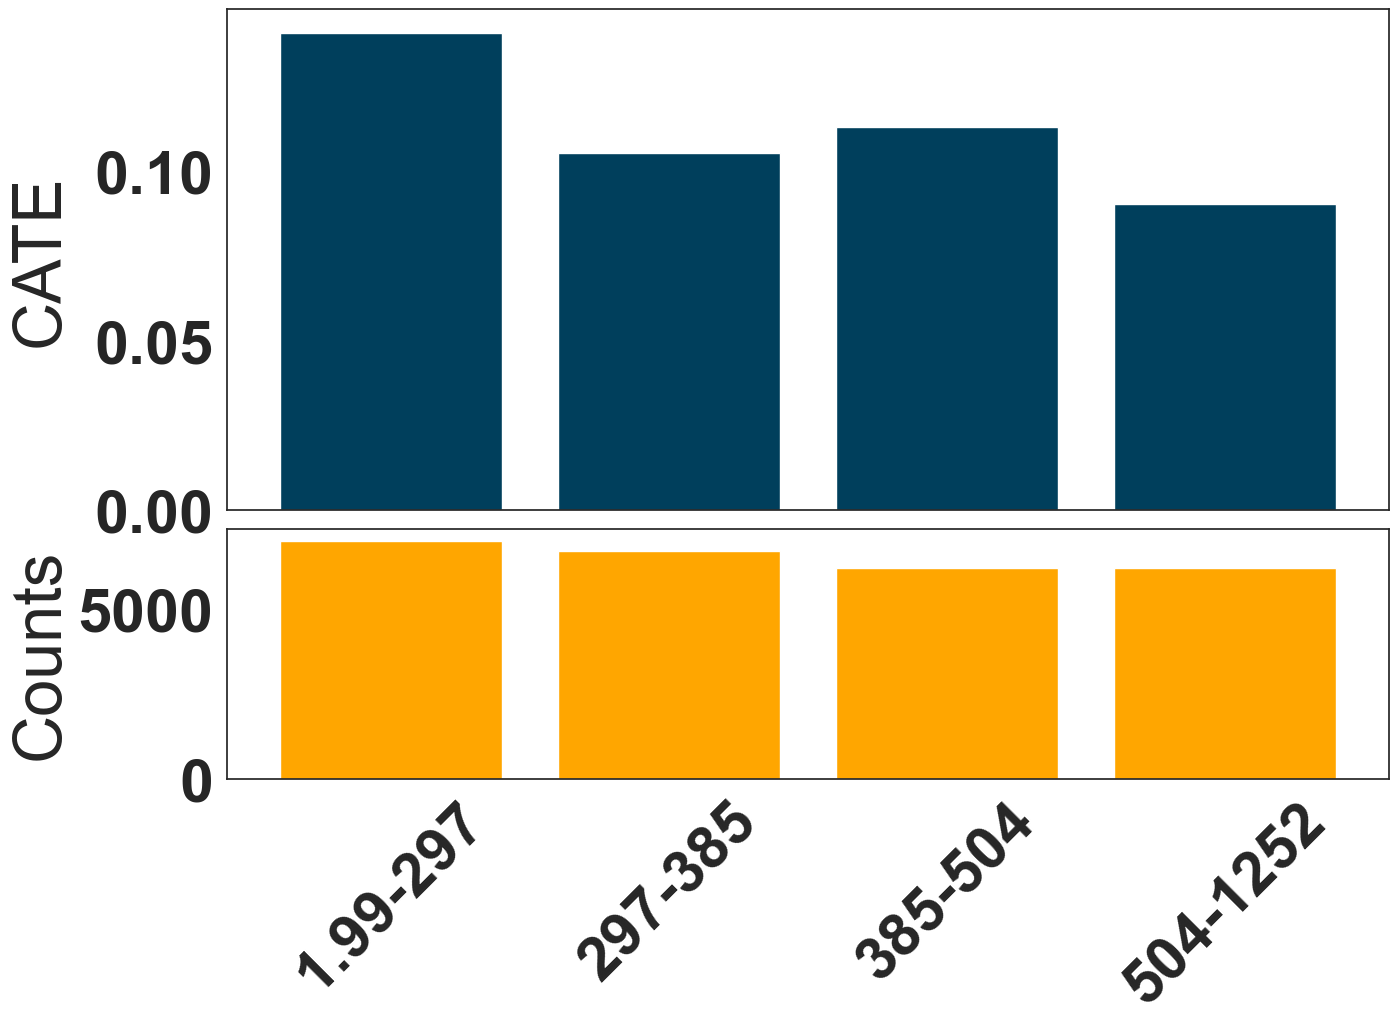

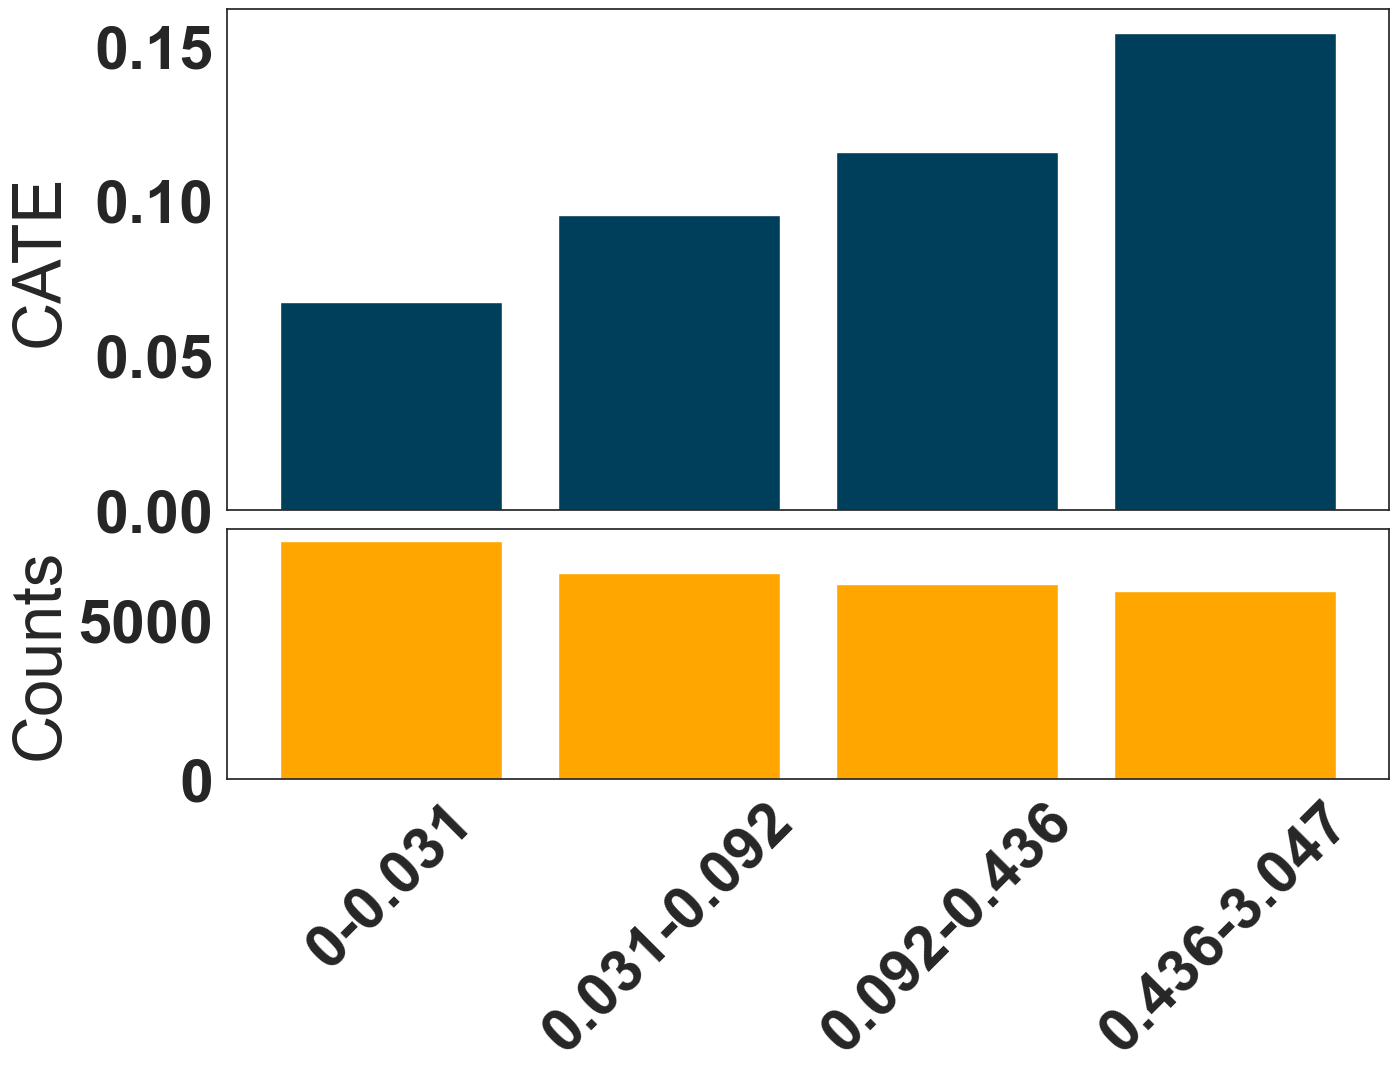

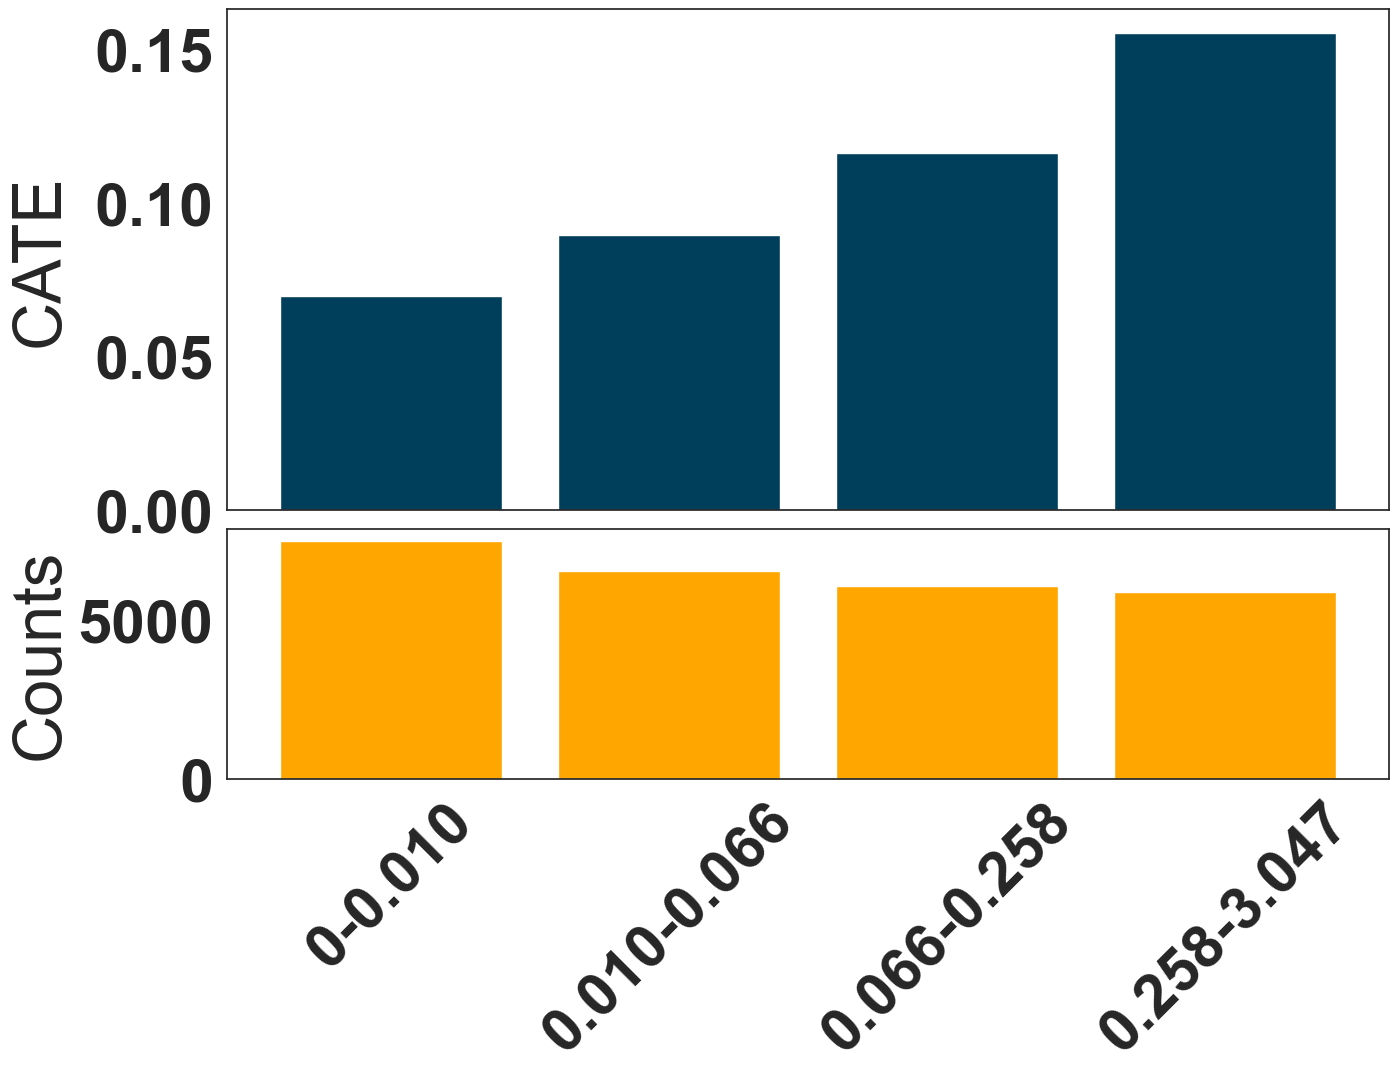

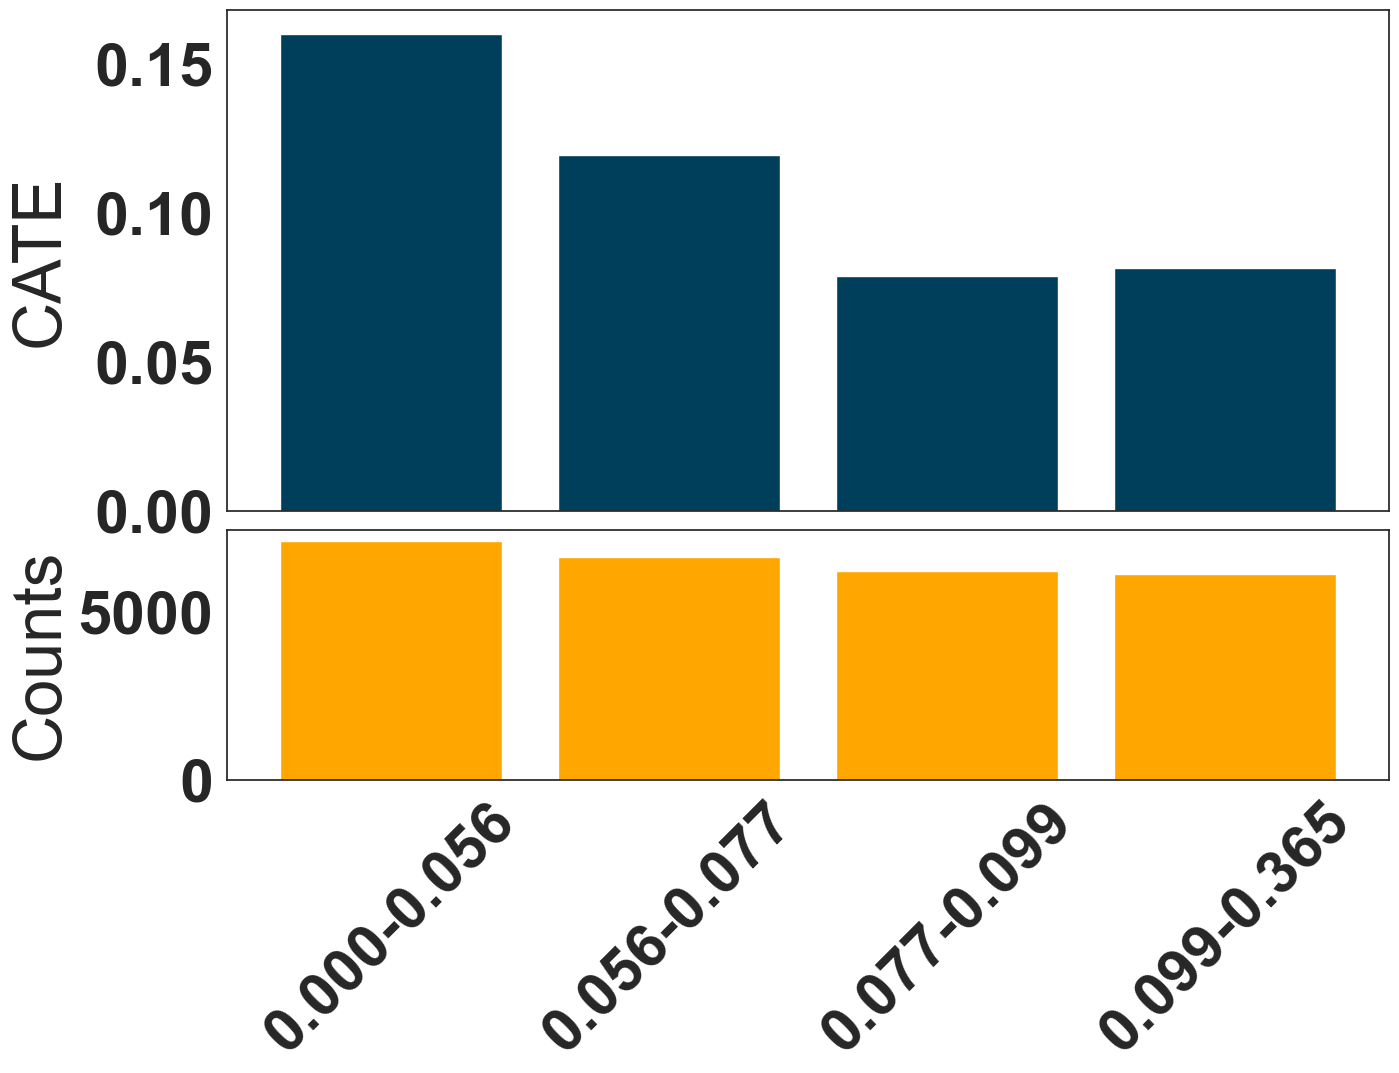

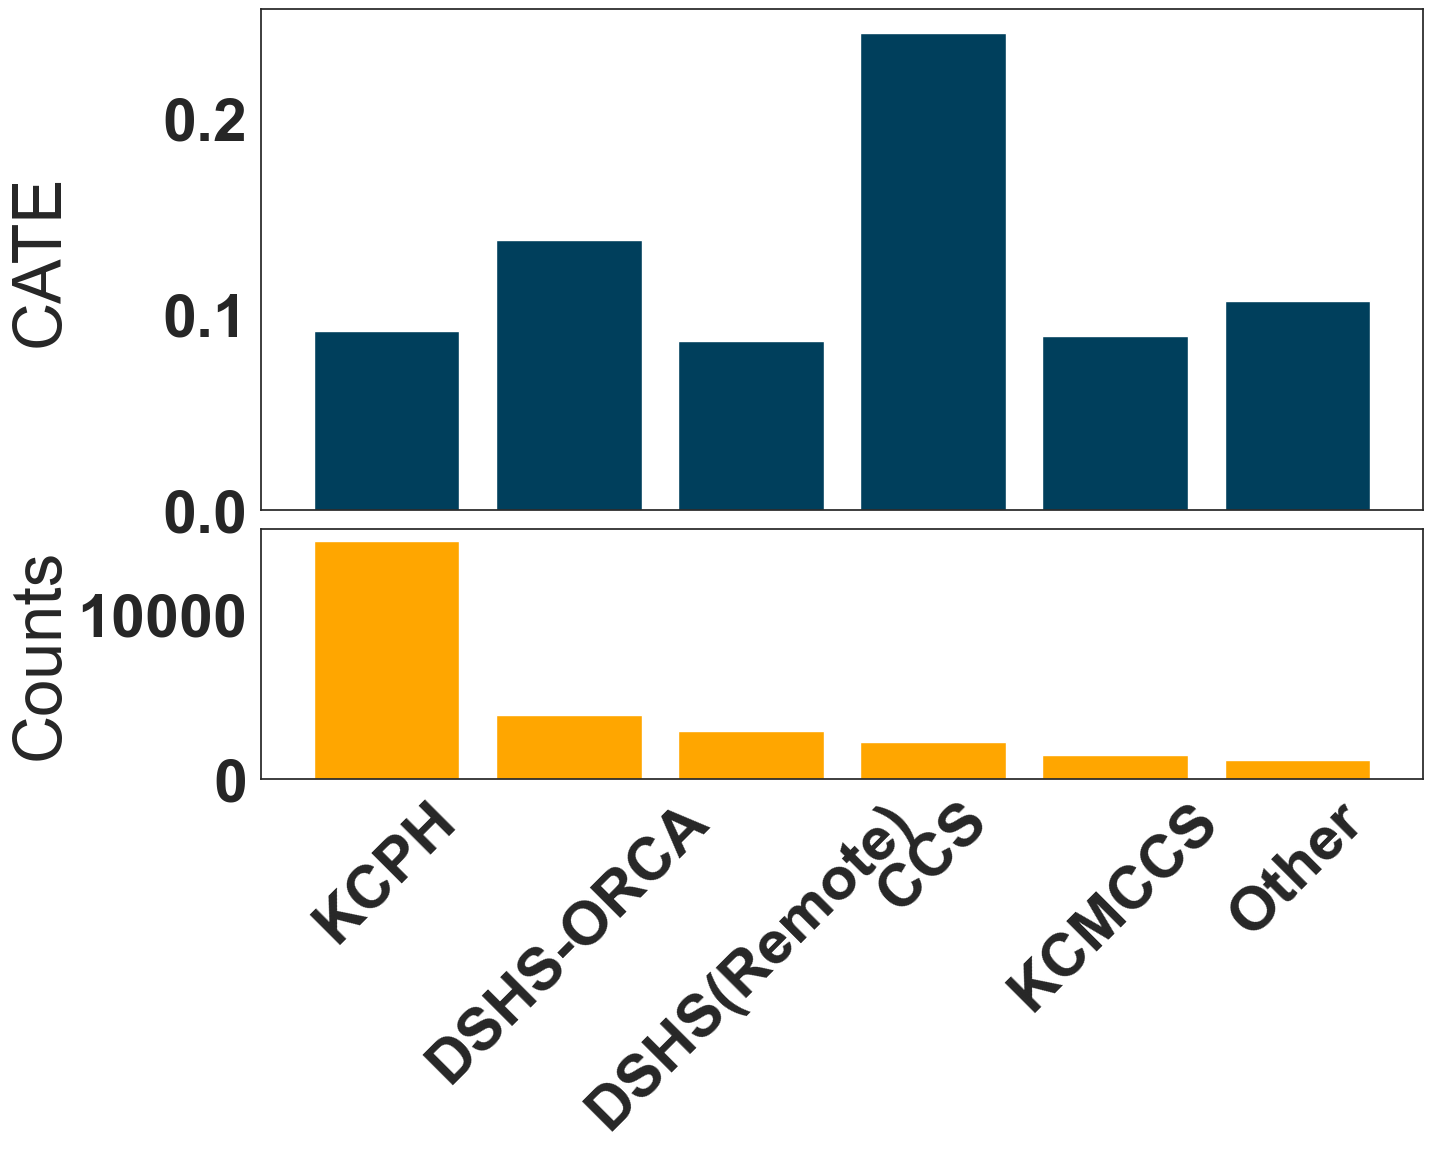

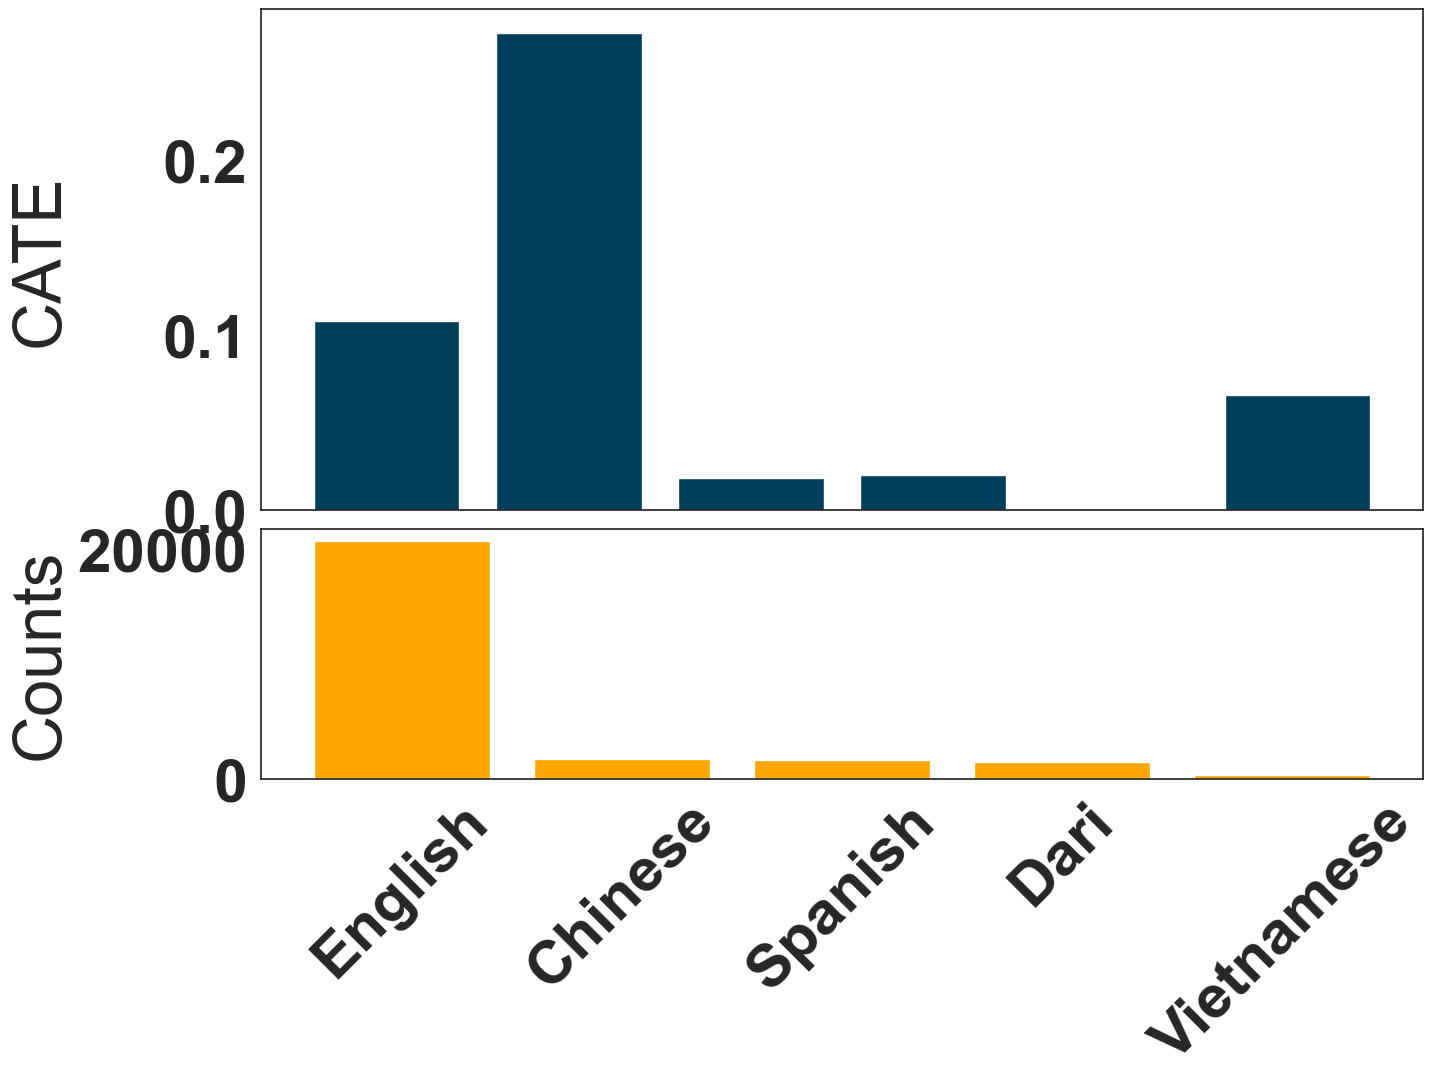

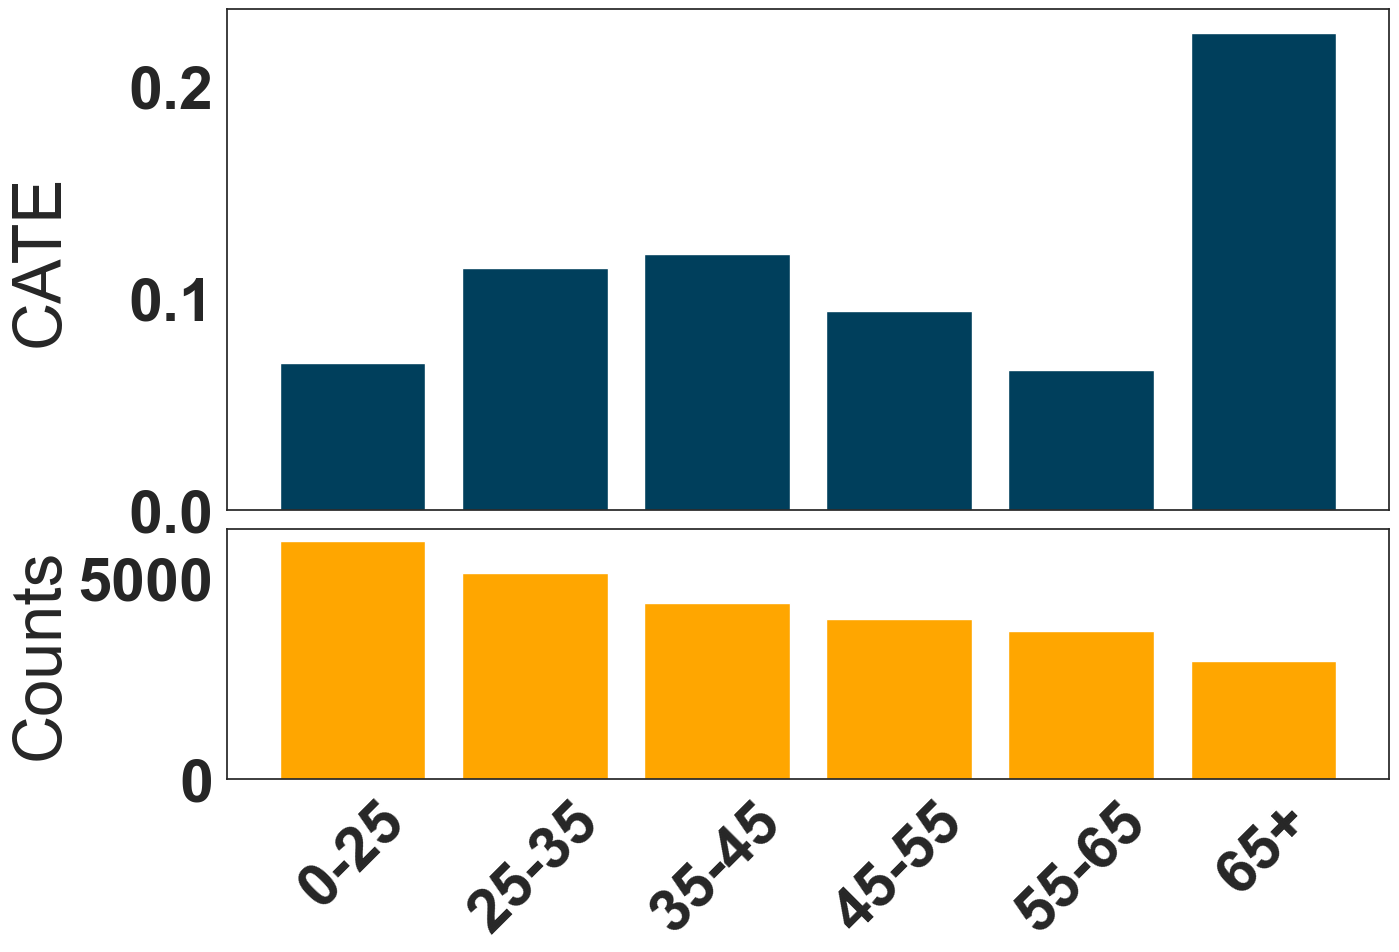

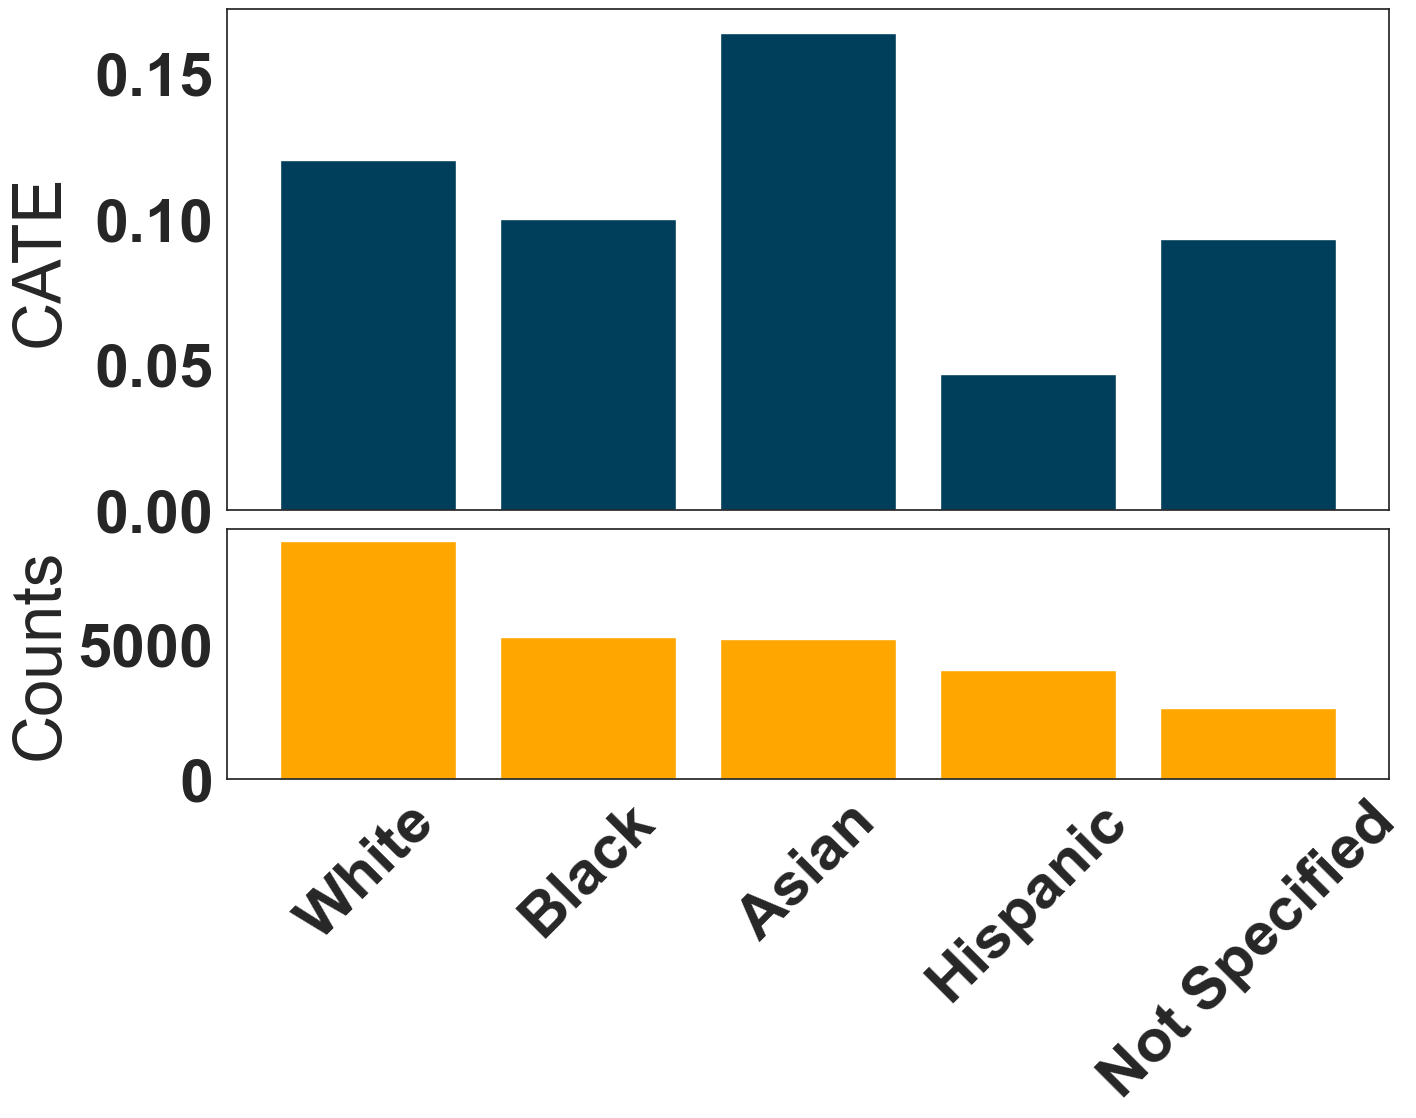

In [37]:
from matplotlib import gridspec

def plot_column_CATE(covariates = [], dataframe=df_dic,response = 'reenrollment'):
    """
    Plot CATEs and counts, 12-06-2023
    """
    for covariate in covariates:
        fig = plt.figure(figsize=(15,10))
        gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
        df = dataframe[covariate]
        sns.set_theme(style="white", font_scale=4)
        # df = df.sort_values(df.index, ascending=False)

        if covariate == 'RaceDesc': 
            dic_race_rename = {'0': 'White','1': 'Black','2': 'Asian','3': 'Hispanic','4': 'Not Specified','5': 'Other',
                               '6': 'American Indian','7': 'Multi-Racial','8': 'Pacific Islander','*': 'Unmatched'}
            df = df.rename(index=dic_race_rename)

        elif covariate == 'Language':
            dic_language_rename = {"0":"English", "1":"Chinese", "2":"Spanish", 
                                "3":"Dari", "4":"Vietnamese", "5":'Other'}
            df = df.rename(index=dic_language_rename)

        elif covariate == 'Agency':
            dic_agency_rename = {"0":"KCPH", "1":"DSHS-ORCA", "2":"DSHS(Remote)", 
                                 "3":"CCS", "4":"KCMCCS", "5":'Other'}
            df = df.rename(index=dic_agency_rename)
        elif covariate == 'Age_bin': 
            #0,25,35,45,55,65,200 bins
            df = df.rename(index={"0":"0-25","1":"25-35",
                        "2":"35-45",
                        "3":"45-55",
                        "4":"55-65",
                        "5":"65+"})
        elif covariate == 'OverallJobAccess_quantileNum_4q':
            df = df.rename(index={"0":"0.063-0.81","1":"0.81-1.26",
                        "2":"1.26-1.81",
                        "3":"1.81-3.63"})
        elif covariate == 'lowwagelaborforce_quantileNum_4q':
            df = df.rename(index={"0":"1.99-297","1":"297-385",
                        "2":"385-504",
                        "3":"504-1252"})
        elif covariate == 'Access30Transit_quantileNum_4q':
            df = df.rename(index={"0":"0-0.031","1":"0.031-0.092",
                        "2":"0.092-0.436",
                        "3":"0.436-3.047"})
        elif covariate == 'Access30Transit_ts_quantileNum_4q':
            df = df.rename(index={"0":"0-0.010","1":"0.010-0.066",
                        "2":"0.066-0.258",
                        "3":"0.258-3.047"})
        elif covariate == 'spatialmismatch_quantileNum_4q':
            df = df.rename(index={"0":"0.000-0.056","1":"0.056-0.077",
                        "2":"0.077-0.099",
                        "3":"0.099-0.365"})
        else:
            print("Error: covariate not found.")    
        

        ax0 = plt.subplot(gs[0])
        ax0.bar(df[['CATE']].index, 
                df.CATE.values, 
                color='#003F5C')
        plt.xticks([], []) # have no labels on the upper plot. 
        plt.ylabel('CATE') # have Y-label on the upper plot.

        ax1 = plt.subplot(gs[1])
        ax1.bar(df[['Counts']].index, 
                df.Counts.values, 
                color='#FFA600')
        plt.ylabel('Counts')
        plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
        
        # if covariate in ['Language', 'Agency']:
           
        #     plt.xlabel(covariate)
        # elif covariate in ['RaceDesc']:
        #     plt.xlabel('Race')
        # elif covariate in ['Age_bin']:
        #     plt.xlabel('Age Bin')
        # elif covariate in ['OverallJobAccess_quantileNum_4q']:
        #     plt.xlabel('Overall Job Access Score')
        # elif covariate in ['lowwagelaborforce_quantileNum_4q']:
        #     plt.xlabel('Low Wage Labor Force Score')
        # elif covariate in ['Access30Transit_quantileNum_4q']:
        #     plt.xlabel('Access to Transit Score')
        # elif covariate in ['Access30Transit_ts_quantileNum_4q']:
        #     plt.xlabel('Access to Transit Score(TS)') 
        # elif covariate in ['spatialmismatch_quantileNum_4q']:
        #     plt.xlabel('Spatial Mismatch Score')
        # else:
        #     plt.xlabel(covariate)
            
        gs.update(hspace=0.05) # set the spacing between axes. 

        #plt.suptitle('Asian riders are most likely to reenroll in SAP')
        fig.align_ylabels([ax0, ax1])
        #plt.tight_layout()
        plt.savefig(f'figs/{response}/{covariate}.pdf',
                bbox_inches='tight', dpi=300)
    
col = ['OverallJobAccess_quantileNum_4q','lowwagelaborforce_quantileNum_4q','Access30Transit_quantileNum_4q',
        'Access30Transit_ts_quantileNum_4q','spatialmismatch_quantileNum_4q',
        'Agency','Language','Age_bin','RaceDesc']


plot_column_CATE(covariates = col,dataframe=df_dic, response = 'reenrollment')

## Ridership

In [38]:
LIFT_b = LIFT_boardings.append(LIFT_boardings_update)
LIFT_b = LIFT_b.drop_duplicates()


In [39]:
LIFT_boardings['week']=pd.to_datetime(LIFT_boardings['week'])
LIFT_boardings_update['week']=pd.to_datetime(LIFT_boardings_update['week'])

In [40]:
missing=LIFT_boardings_update["week"].min()-LIFT_boardings["week"].max()

print(f'We have {missing.days} days of missing data')

We have 7 days of missing data


In [41]:
LIFT_b.shape

(1783168, 8)

In [42]:
registry = merged.copy()

In [43]:

registry['DateIssued'] = pd.to_datetime(registry['DateIssued'])
#bin continous variables
# Map all string categorical variables to numbers.
race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, "Other": 4, 'American Indian or Alaska Native': 4, "Multi-Racial": 4, "Native Hawaiian or Other Pacific Islander": 4}
registry['RaceDesc'] = registry['RaceDesc'].map(race)
top5 = registry.value_counts("CardIssuingAgency").index[:5]
top5.tolist()


language = {"English": 0, "Chinese": 1, "Spanish": 2, "Dari": 3, "Vietnamese": 4, 'Other': 5}
registry['Language'] = registry['LanguageSpoken'].map(language)

a = {"King County Public Health": 0, "DSHS - ORCA LIFT (remote enrollment)": 1, "DSHS - subsidized annual pass (remote enrollment)": 2, "CCS": 3, "KCMCCS": 4, 'Other': 5}
registry['Agency'] = registry['CardIssuingAgency'].map(a)

a = {"10": 0, "Subsidized Annual Pass": 1, "NA": 2, "70": 3, "20": 4, '50': 5,  '15': 6, 'Misc. Pass':7, '30': 8, 'Passport': 9 }
registry['SAP'] = registry['Initial_Load'].map(a)

registry['Age_bin']=pd.cut(x = sap['Age'],
                        bins = [0,25,35,45,55,65,200], 
                        labels = [0,1,2,3,4,5])
registry['stage']=registry['stage'].apply(lambda x: 0 if x == 1 else 1)

registry["SAP"] = np.where(registry["Initial_Load"] == "Subsidized Annual Pass", 1, 0)

In [44]:
# Filter and preprocess LIFT_b data
LIFT_b['week'] = pd.to_datetime(LIFT_b['week'])
LIFT_b = LIFT_b[(LIFT_b['week'] >= "2021-04-01")] # Select for boardings after 10/20/2020 + 6 months

# Select King County Metro boardings
boardings = LIFT_b.loc[LIFT_b['King County Metro'].notna(), ['King County Metro', 'week', 'card_id']]

# Merge with registry data and rename to ridership_merged
ridership_merged = pd.merge(registry, boardings, how='left', on='card_id')
ridership_merged['King County Metro'] = ridership_merged['King County Metro'].replace(np.nan, 0)
ridership_merged['week'] = ridership_merged['week'].replace(np.nan, "2022-04-01")
ridership_merged['DateIssued'] = pd.to_datetime(ridership_merged['DateIssued'])

# Extract the last character from the 'card_id' column and assign it to the 'stage' column
ridership_merged['stage'] = ridership_merged['card_id'].str[-1:].astype(int)

# Remove the last two characters from the 'card_id' column and assign the result to the 'id' column
ridership_merged['user_id'] = ridership_merged['card_id'].str[:-2].astype(int)

# Select boardings 6 months post-registration
boardings = ridership_merged[ridership_merged.week - ridership_merged.DateIssued > np.timedelta64(180, 'D')]

# # Rename and aggregate boardings by user_id and stage

total_boardings = boardings.groupby(["user_id", "stage"]).sum()[['King County Metro']].rename(columns={'King County Metro': 'total_boardings'})
boardings = boardings.merge(total_boardings, on='user_id', how='left')






In [45]:
boardings["RaceDesc"].value_counts()

0.0    56158
4.0    33545
1.0    29579
3.0    24716
2.0    20809
Name: RaceDesc, dtype: int64

In [46]:

# Select relevant columns, drop duplicates, and handle missing values
user_boardings = boardings.loc[:, ~boardings.columns.isin(['week', 'King County Metro', 'DateIssued', 'user_id'])].drop_duplicates()
user_boardings = user_boardings[user_boardings['Age_bin'].notna()]
user_boardings["RaceDesc"] = user_boardings["RaceDesc"].fillna(value="Other")



In [47]:


# Select final columns
flame_boardings = user_boardings.loc[:, user_boardings.columns.isin(['RaceDesc', 'OverallJobAccess_quantileNum_4q', 'lowwagelaborforce_quantileNum_4q',
       'Access30Transit_quantileNum_4q', 'Access30Transit_ts_quantileNum_4q', 'spatialmismatch_quantileNum_4q', 'SAP',
       'Agency', 'Language', 'stage', 'Age_bin', 'total_boardings'])]


In [48]:
flame_boardings.head()

RaceDesc  stage  OverallJobAccess_quantileNum_4q  \
0      2.0      8                                3   
1      1.0      6                                3   
5      1.0      5                                3   
6      0.0      5                                3   
7      1.0      5                                3   

   lowwagelaborforce_quantileNum_4q  Access30Transit_quantileNum_4q  \
0                                 3                               3   
1                                 3                               3   
5                                 3                               3   
6                                 3                               3   
7                                 3                               3   

   Access30Transit_ts_quantileNum_4q  spatialmismatch_quantileNum_4q  \
0                                  3                               2   
1                                  3                               2   
5                                  3                               2   
6                                  3                               2   
7                                  3                               2   

   Language  Agency  SAP Age_bin  total_boardings  
0       0.0     3.0    1       2              0.0  
1       0.0     NaN    0       2             19.0  
5       0.0     4.0    0       3              0.0  
6       0.0     3.0    1       3              0.0  
7       0.0     3.0    1       2              0.0

In [49]:
flame_boardings['total_boardings'] = flame_boardings['total_boardings'].fillna(0)

In [50]:
flame_boardings['RaceDesc'] = pd.to_numeric(flame_boardings['RaceDesc'], errors='coerce', downcast='integer')

# Replace NaN values with 4
flame_boardings['RaceDesc'] = flame_boardings['RaceDesc'].fillna(4).astype(int)

In [51]:
model_flame_ridership = dame_flame.matching.FLAME(repeats=False, 
                                            verbose=3, 
                                            early_stop_iterations=30, 
                                            stop_unmatched_t = True, 
                                            adaptive_weights='ridge', 
                                            want_pe=True)

In [52]:
model_flame_ridership.fit(holdout_data=False, 
                    treatment_column_name='SAP', 
                    outcome_column_name='total_boardings')

result_flame_predict_ridership = model_flame_ridership.predict(flame_boardings)

There is missing data in this dataset. The default missing data handling is being done, so we are not matching on any missing values in the matching set
There is missing data in this dataset. The default missing data handling is being done, so we are running MICE on 10 imputed holdout datasets
Iteration number:  1
	Number of matched groups formed in total:  329
	Unmatched treated units:  2835 out of a total of  3350 treated units
	Unmatched control units:  9220 out of a total of  10077 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  1372
	Number of matches made so far:  1372
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  416
	Unmatched treated units:  2725 out of a total of  3350 treated units
	Unmatched control units:  9084 out of a total of  10077 control units
	Predictive error of covariates chosen this iteration:  15307.346091730962
	Number of

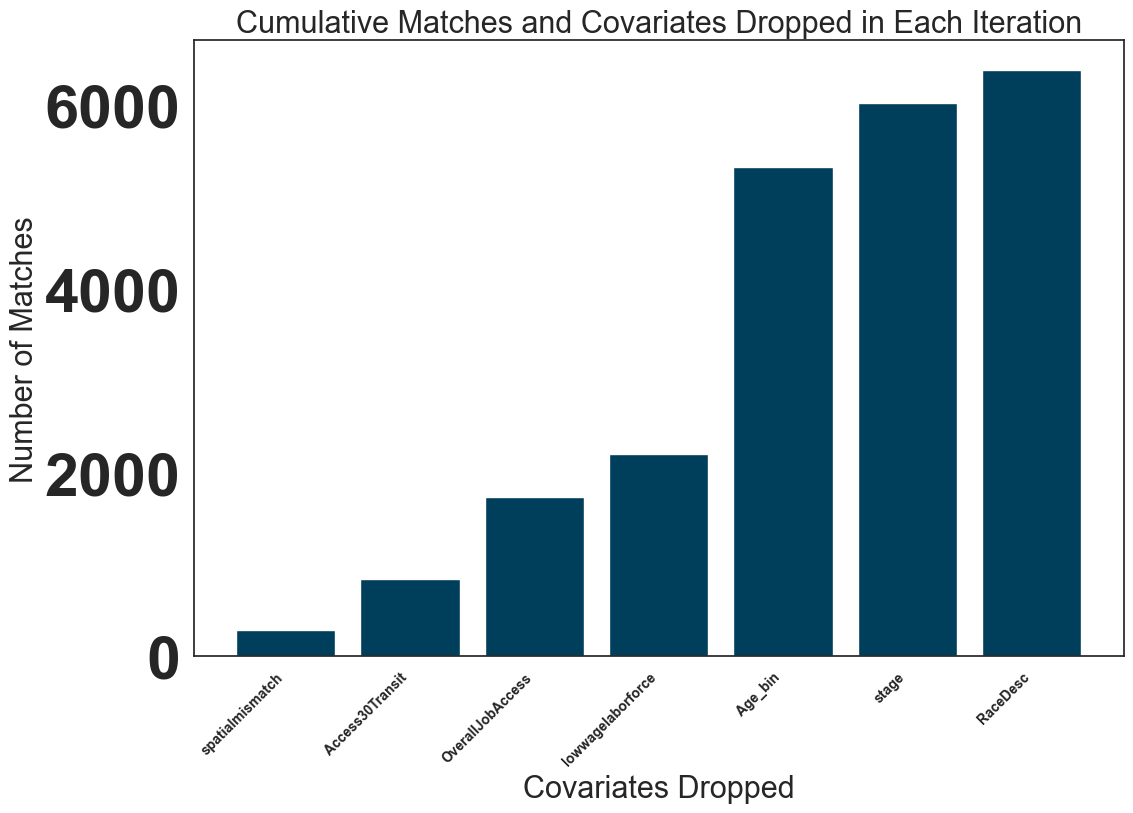

In [111]:
import matplotlib.pyplot as plt

# Data from the logs
covariates_dropped = [
     'spatialmismatch', 'Access30Transit', 'OverallJobAccess', 'lowwagelaborforce', 'Age_bin', 'stage', 'RaceDesc'
]
matches_in_iteration = [ 289, 847, 1731, 2200, 5326, 6028, 6385]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot for the cumulative number of matches
bars = ax.bar(range(len(covariates_dropped)), matches_in_iteration, color='#003f5c')

# Adding labels and title
ax.set_ylabel('Number of Matches', fontsize=22)
ax.set_xlabel('Covariates Dropped', fontsize=22)
ax.set_title('Cumulative Matches and Covariates Dropped in Each Iteration', fontsize=22)

# Set x-axis ticks and labels
ax.set_xticks(range(len(covariates_dropped)))
ax.set_xticklabels(covariates_dropped, rotation=45, ha='right', fontsize=10)

plt.show()


In [54]:
# ATE Estimate
ate_ridership = dame_flame.utils.post_processing.ATE(model_flame_ridership)
ate_ridership

8.434413189712352

### Generate Ridership Plots

In [55]:
# Calculate the quantiles for ATE.
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2, model_flame_ridership, flame_boardings)

cate_lst = create_cate_lst(size, cate_all)

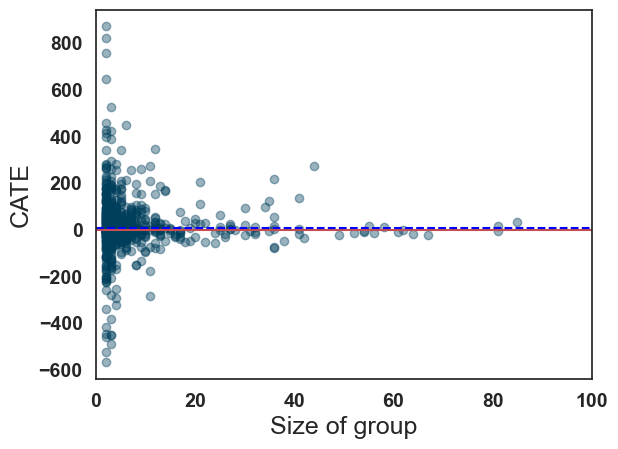

In [56]:
# Scatter Plot for CATE
cors = {True:"green", False:"green"}
 #hisp = pd.Series(in_hisp)

plt.scatter(size, cate_all, c = "#003f5c", alpha=0.4)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=ate_ridership, color='blue', linestyle='--')
plt.xlim(0,100)
plt.xlabel('Size of group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)
# plt.title("Visualizing Enrollment CATE of matched groups by size", fontsize=14)

plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.tick_params( labelsize=14)

plt.savefig('figs/ridership/ate_scatter.pdf', bbox_inches="tight", dpi=300)

### Conditional Average Treatment Effects By Race, Access to Transit

In [57]:
# race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
(size, cate_all, in_asian, size_asian, cate_asian) = create_df_scatter("RaceDesc", 2,model_flame_ridership, flame_boardings)



In [108]:
## Conf. Interval for Asian CATE estimates
cate_lst = create_cate_lst(size_asian, cate_asian)
mean_cate_asian = sum(cate_lst)/len(cate_lst)
mean_cate_asian=15.45

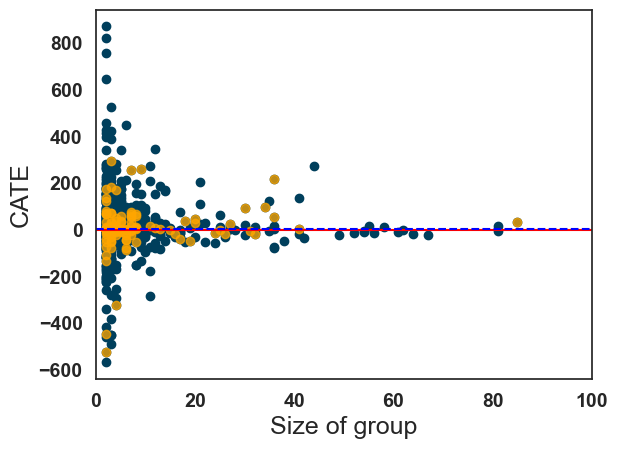

In [107]:
# Scatter Plots displaying the CATEs for matched groups with Asian individuals

cors = {True:'#bc5090', False:'#ffa600'}
asian = pd.Series(in_asian)

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_asian, cate_asian, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='red', linestyle='-')
plt.axhline(y=mean_cate_asian, color='blue', linestyle='--')

plt.xlim(0,100)
plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.tick_params( labelsize=14)

plt.savefig('figs/ridership/asian_ridership.pdf', bbox_inches="tight", dpi=300)

In [60]:
# race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
# Hispanic
(size, cate_all, in_hisp, size_hispanic, cate_hispanic) = create_df_scatter("RaceDesc", 3,model_flame_ridership, flame_boardings)


In [61]:
## mean cate hispanic race
cate_hispanic_lst = create_cate_lst(size_hispanic, cate_hispanic)
mean_cate_h = sum(cate_hispanic_lst)/len(cate_hispanic_lst)
mean_cate_h

-20.59597255031434

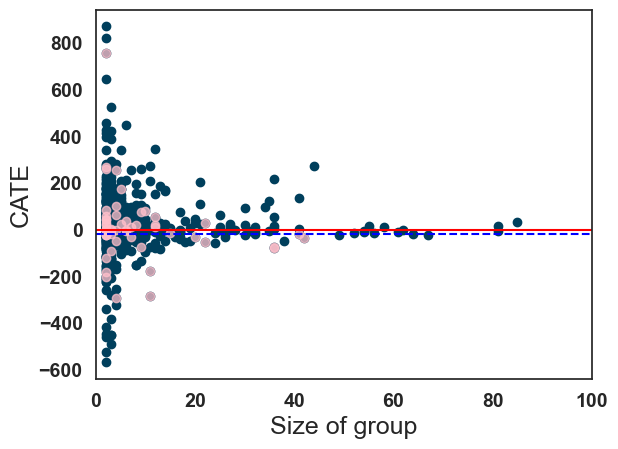

In [62]:
# Scatter plot Hispanic Individuals.

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_hispanic, cate_hispanic, c = "pink", alpha=.75)

plt.axhline(y=0.0, color='red', linestyle='-')
plt.axhline(y=mean_cate_h, color='blue', linestyle='--')
plt.xlim(0,100)
plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.tick_params( labelsize=14)

plt.savefig('figs/ridership/hispanic_ridership.pdf', bbox_inches="tight",dpi=300)

In [63]:
# race = {"White": 0, "Black or African American": 1, "Asian": 2, "Hispanic or Latino": 3, "Not Specified": 4, 'Other': 5, 'American Indian or Alaska Native': 6, "Multi-Racial": 7, "Native Hawaiian or Other Pacific Islander": 8}
# White
(size, cate_all, in_white, size_white, cate_white) = create_df_scatter("RaceDesc", 0,model_flame_ridership, flame_boardings)


In [64]:
## mean cate white race
cate_w_lst = create_cate_lst(size_white, cate_white)
mean_cate_w = sum(cate_w_lst)/len(cate_w_lst)
mean_cate_w

9.462494574026246

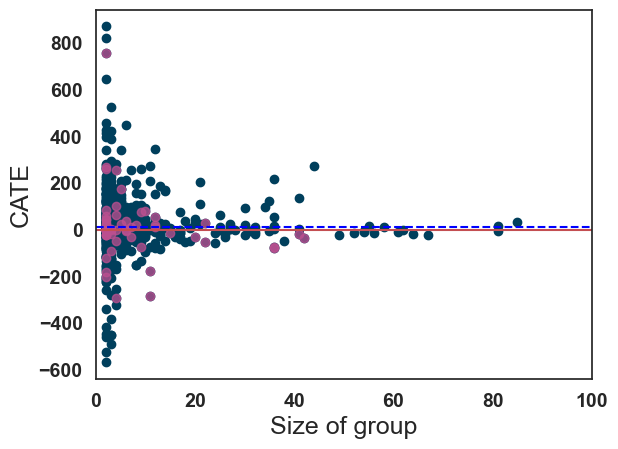

In [65]:
# Scatter plot Hispanic Individuals.

plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_hispanic, cate_hispanic, c = "#bc5090", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=mean_cate_w, color='blue', linestyle='--')
plt.xlim(0,100)
plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.tick_params( labelsize=14)

plt.savefig('figs/ridership/white_ridership.pdf', bbox_inches="tight",dpi=300)

### Overall Job Access

In [66]:
(size, cate_all, in_access_one, size_access_one, cate_access_one) = create_df_scatter("OverallJobAccess_quantileNum_4q", 1,model_flame_ridership, flame_boardings)



In [67]:
## mean cate lowest access to transit
cate_transit1_lst = create_cate_lst(size_access_one, cate_access_one)
mean_transit1_cate = sum(cate_transit1_lst)/len(cate_transit1_lst)
mean_transit1_cate

13.324272723714277

In [68]:
plt.rcParams.update({'font.size': 14})

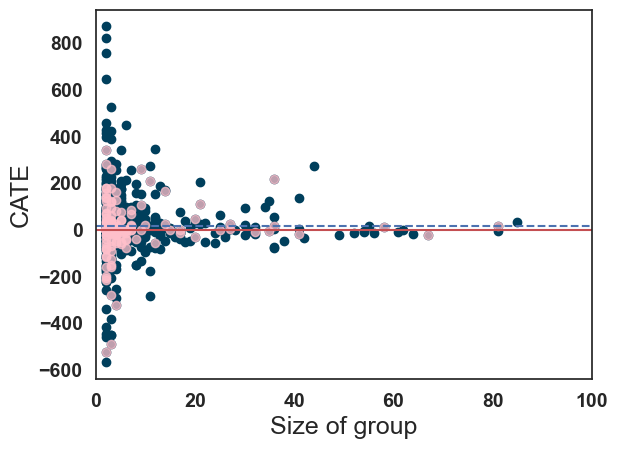

In [69]:
# Scatter plot ("Access30Transit_D", 1) people with Bottom 25% access to transit.

# plot
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_access_one, cate_access_one, c = "pink", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=mean_transit1_cate, color='b', linestyle='--')
plt.xlim(0,100)

plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.tick_params( labelsize=14)

plt.savefig('figs/ridership/job_bottom_ridership.pdf', bbox_inches="tight",dp=300)

In [70]:
(size, cate_all, in_access_four, size_access_four, cate_access_four) = create_df_scatter("OverallJobAccess_quantileNum_4q", 3, model_flame_ridership, flame_boardings)



In [71]:
## mean cate highest access to transit
cate_transit4_lst = create_cate_lst(size_access_four, cate_access_four)
mean_transit4_cate = sum(cate_transit4_lst)/len(cate_transit4_lst)
mean_transit4_cate

14.860236719078994

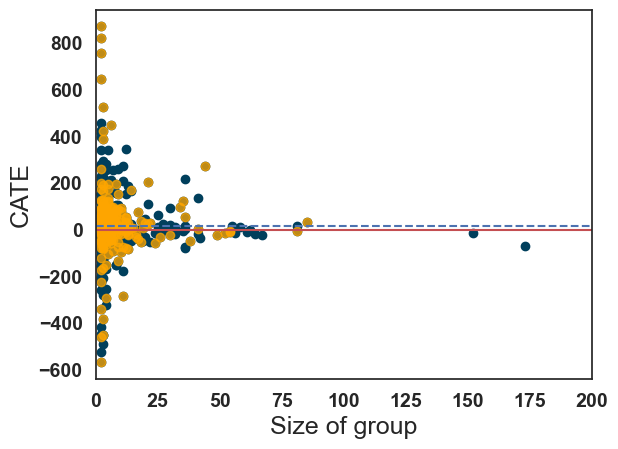

In [72]:
# Scatter plot ("Access30Transit_D", 1) people with Top 25% access to transit.

# plot
plt.scatter(size, cate_all, c = "#003f5c", alpha=1)
plt.scatter(size_access_four, cate_access_four, c = "#ffa600", alpha=.75)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=mean_transit1_cate, color='b', linestyle='--')
plt.xlim(0,200)

plt.xlabel('Size of group', fontsize=18)
plt.ylabel('CATE', fontsize=18)
plt.tick_params( labelsize=14)

plt.savefig('figs/ridership/job_top_ridership.pdf', bbox_inches="tight",dpi=300)

In [73]:
df_dic['RaceDesc']

CATE  Counts  num_units_used
0  0.120126    8855            8253
1  0.100080    5295            4898
2  0.163749    5209            3702
3  0.046883    4057            1568
4  0.093111    2656            4776

In [91]:
col = ['OverallJobAccess_quantileNum_4q','lowwagelaborforce_quantileNum_4q','Access30Transit_quantileNum_4q',
        'Access30Transit_ts_quantileNum_4q','spatialmismatch_quantileNum_4q',
        'Agency','Language','Age_bin','RaceDesc','stage']

df_dic_ridership = export_cate_df(cols, flame_boardings, model_flame_ridership)



Unit 8224 does not have any matches, so can't find the CATE
Unit 8272 does not have any matches, so can't find the CATE
Unit 8276 does not have any matches, so can't find the CATE
Unit 8369 does not have any matches, so can't find the CATE
Unit 8446 does not have any matches, so can't find the CATE
Unit 8494 does not have any matches, so can't find the CATE
Unit 8559 does not have any matches, so can't find the CATE
Unit 8583 does not have any matches, so can't find the CATE
Unit 10837 does not have any matches, so can't find the CATE
Unit 11169 does not have any matches, so can't find the CATE
Unit 11170 does not have any matches, so can't find the CATE
Unit 18055 does not have any matches, so can't find the CATE
Unit 18075 does not have any matches, so can't find the CATE
Unit 18082 does not have any matches, so can't find the CATE
Unit 18848 does not have any matches, so can't find the CATE
Unit 19090 does not have any matches, so can't find the CATE
Unit 19143 does not have any mat

In [99]:
df_dic_ridership['RaceDesc']["CATE"].iloc[3]=mean_cate_h

In [102]:
df_dic_ridership['Agency']=df_dic_ridership['Agency'].reset_index()
df_dic_ridership['Agency'].drop('index',axis=1,inplace=True)
df_dic_ridership['Agency'].index = df_dic_ridership['Agency'].index.map(str)

In [103]:
df_dic_ridership['Language']=df_dic_ridership['Language'].reset_index()
df_dic_ridership['Language'].drop('index',axis=1,inplace=True)
df_dic_ridership['Language'].index = df_dic_ridership['Language'].index.map(str)

In [104]:
df_dic_ridership['Language'].index=df_dic_ridership['Language'].index.map(str)

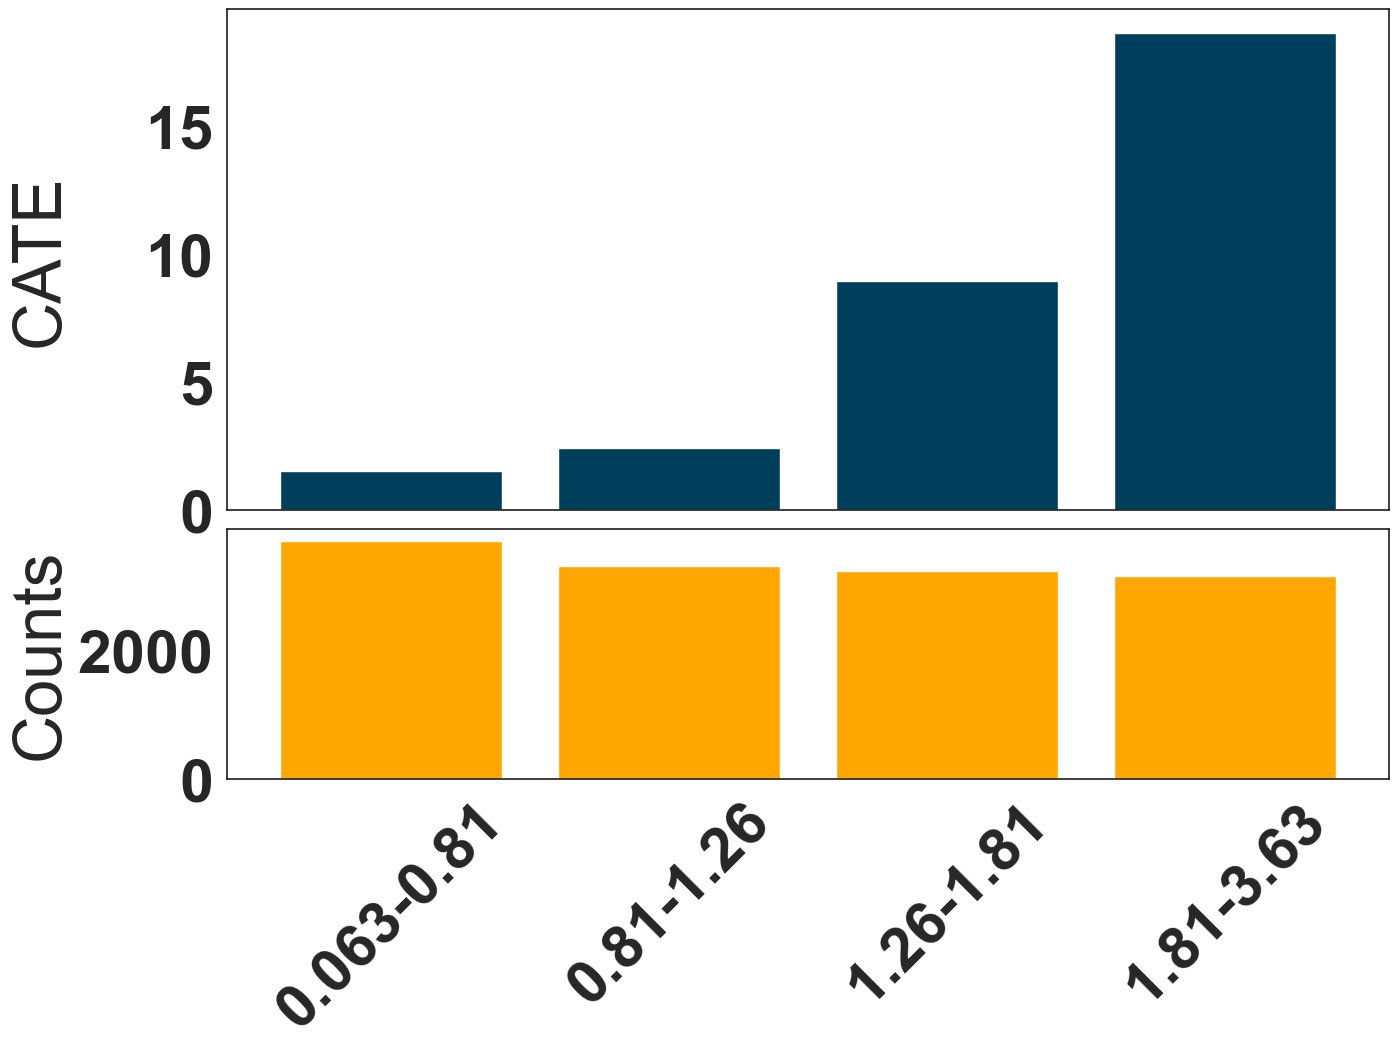

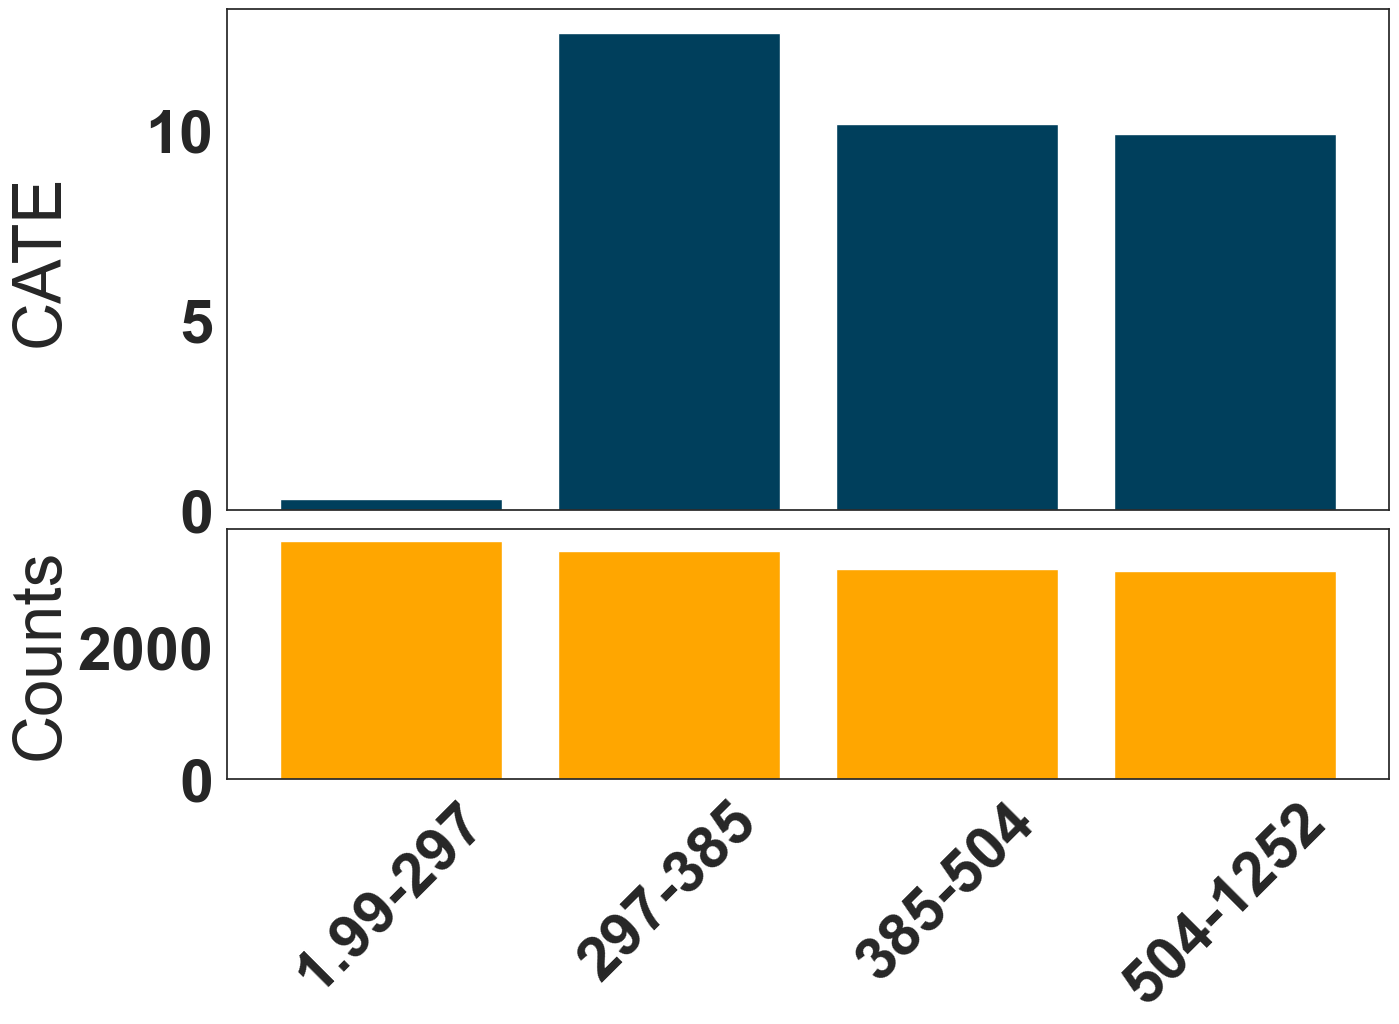

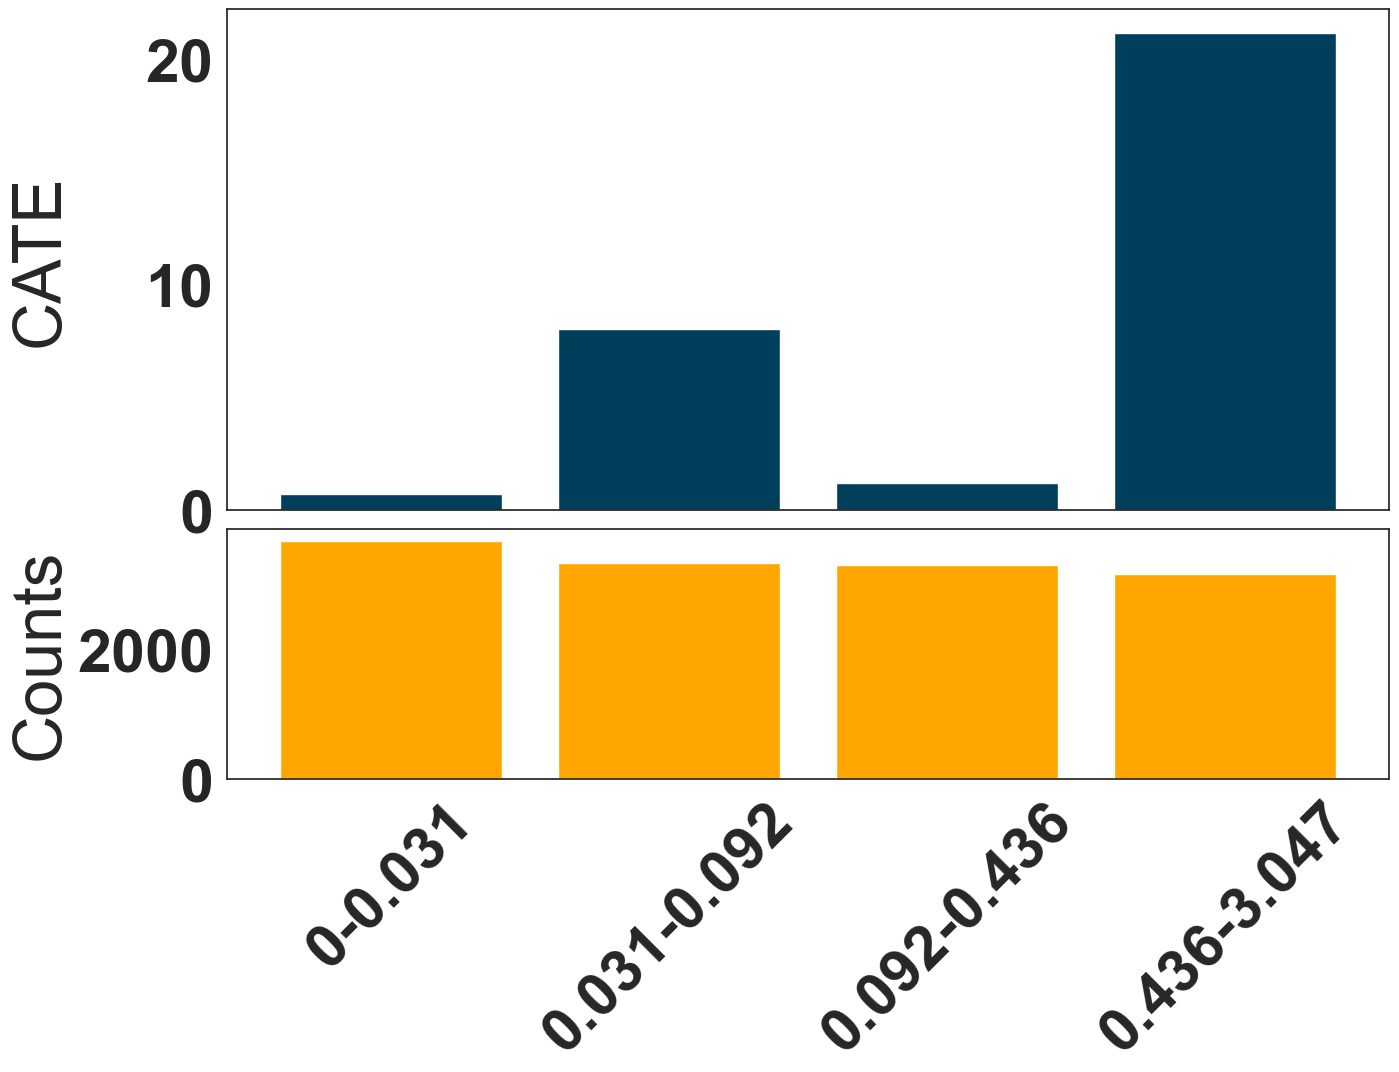

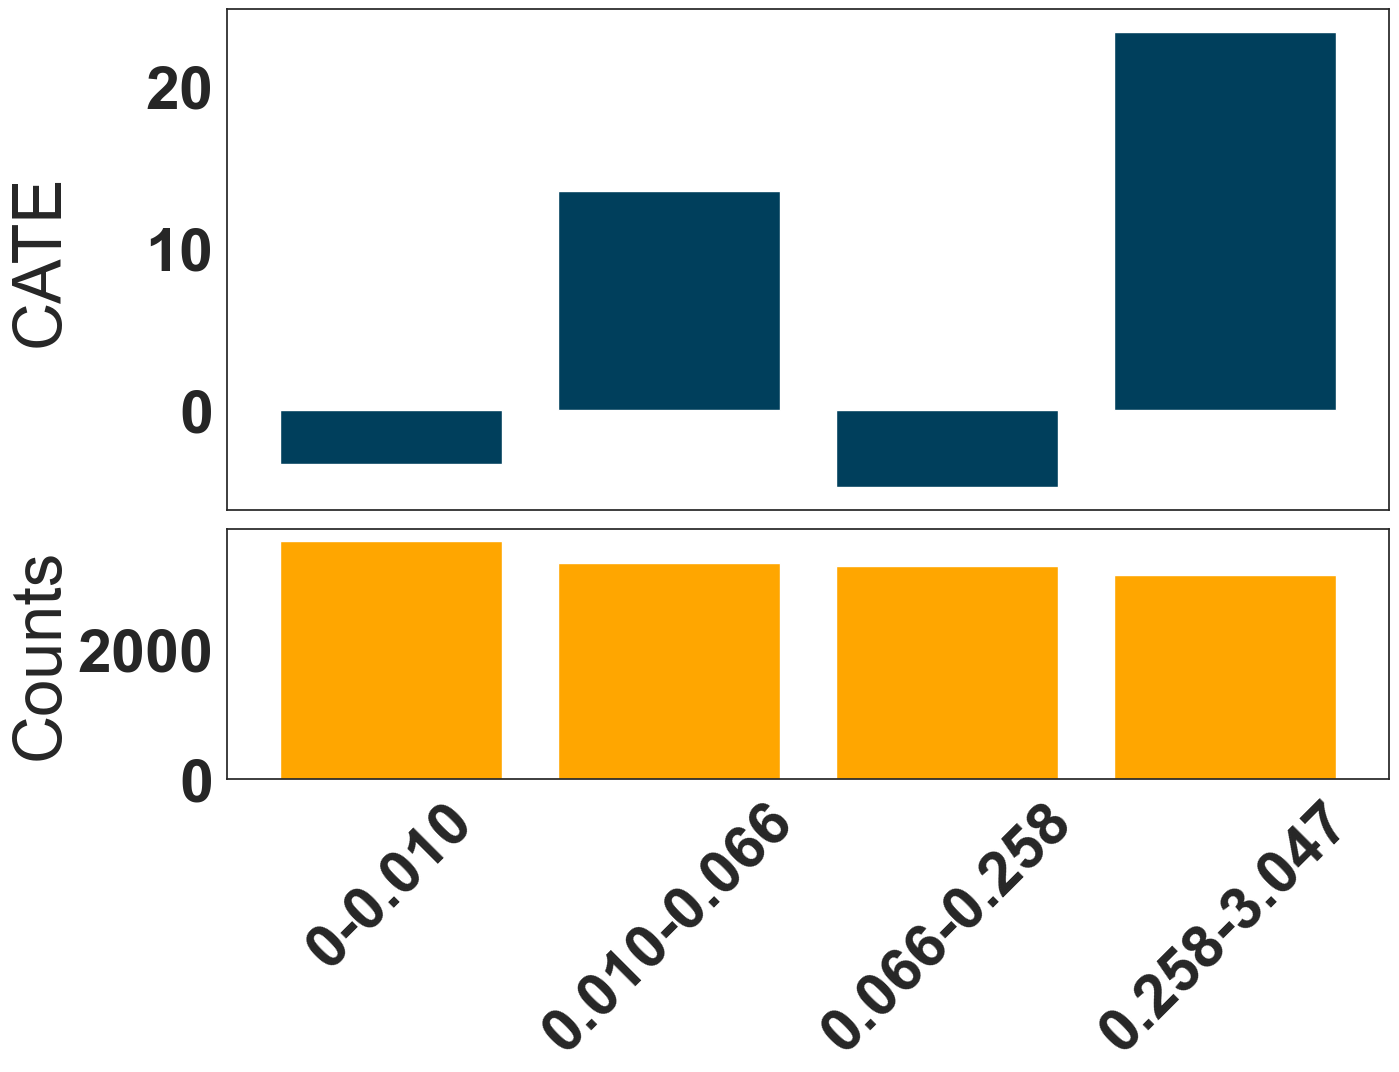

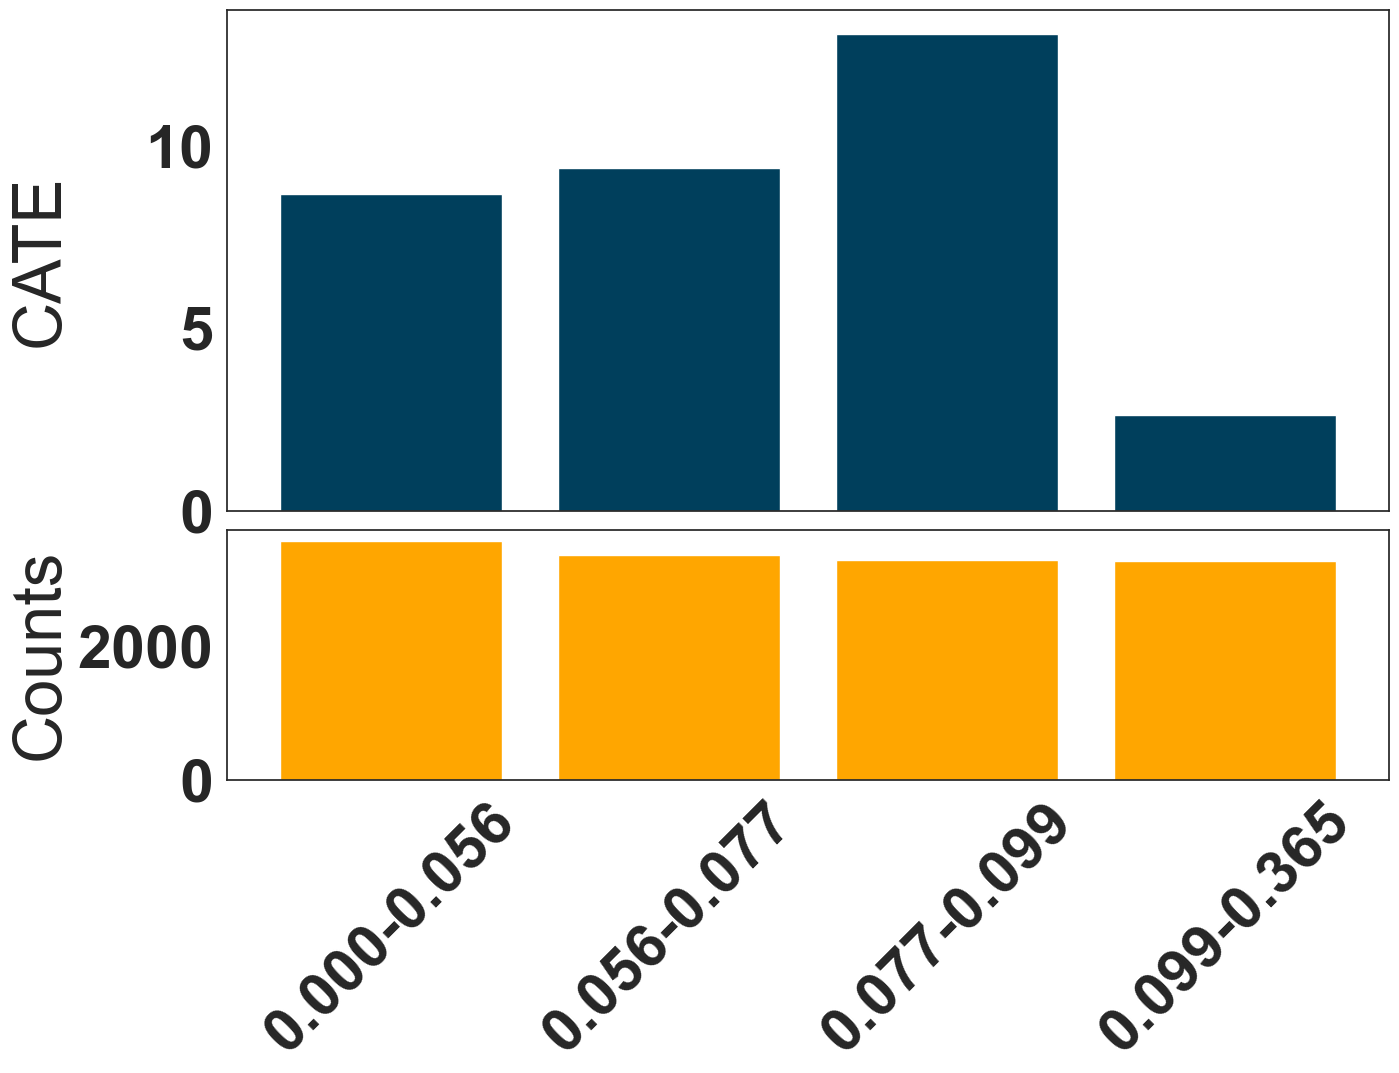

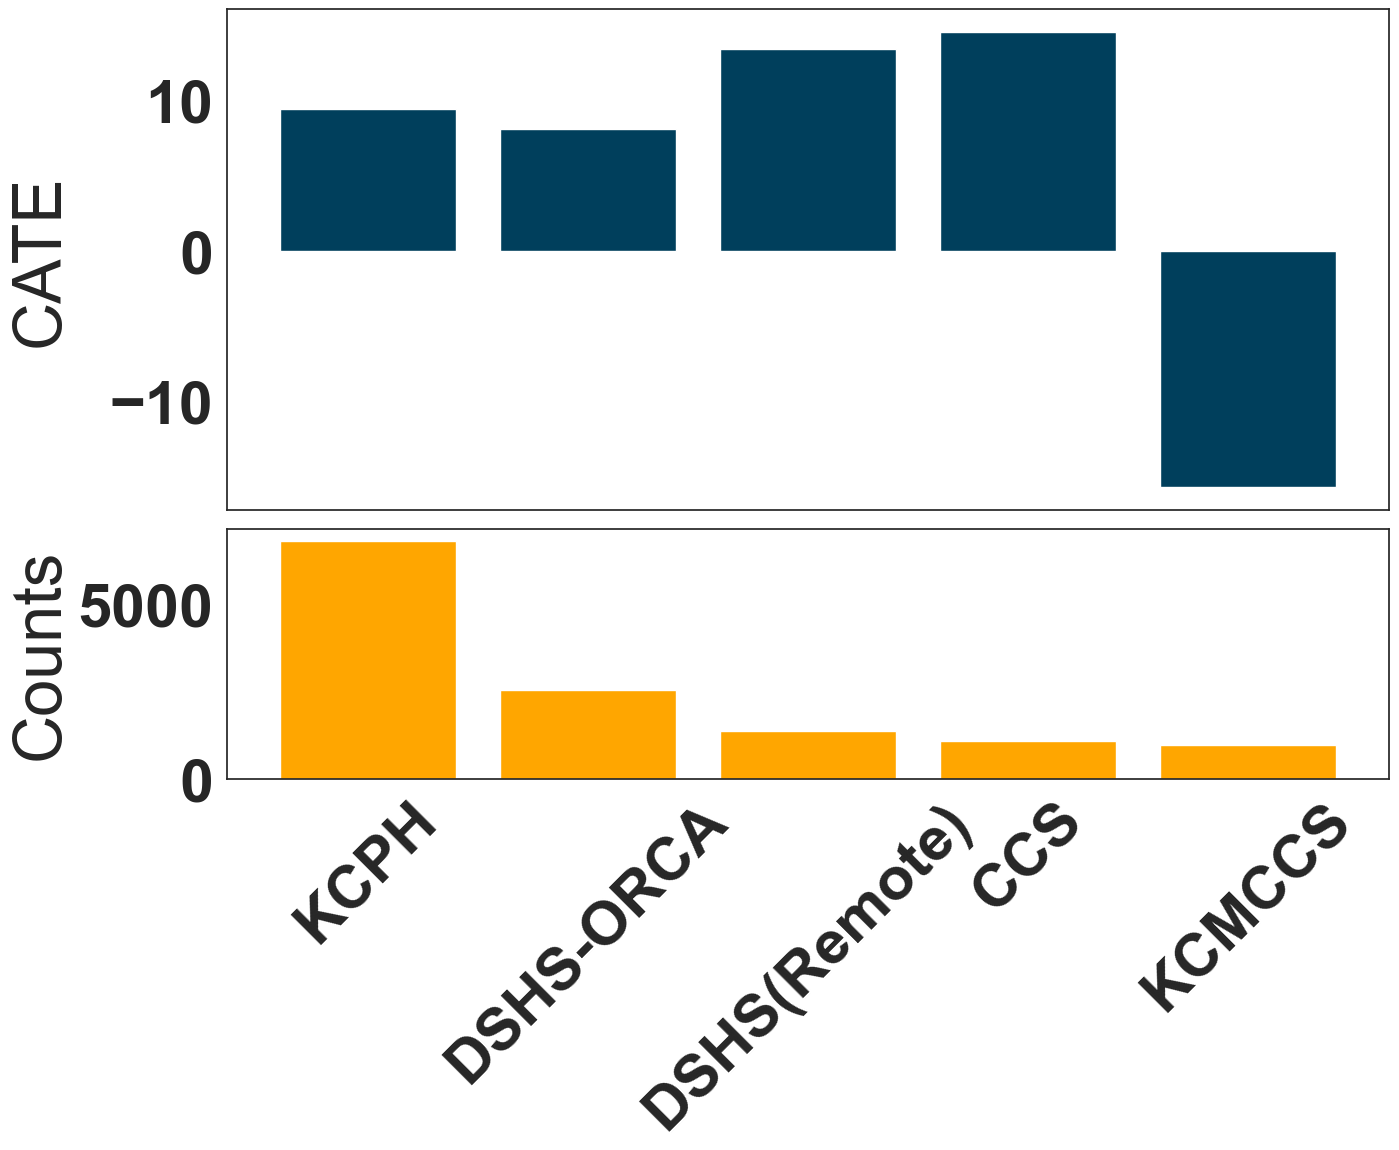

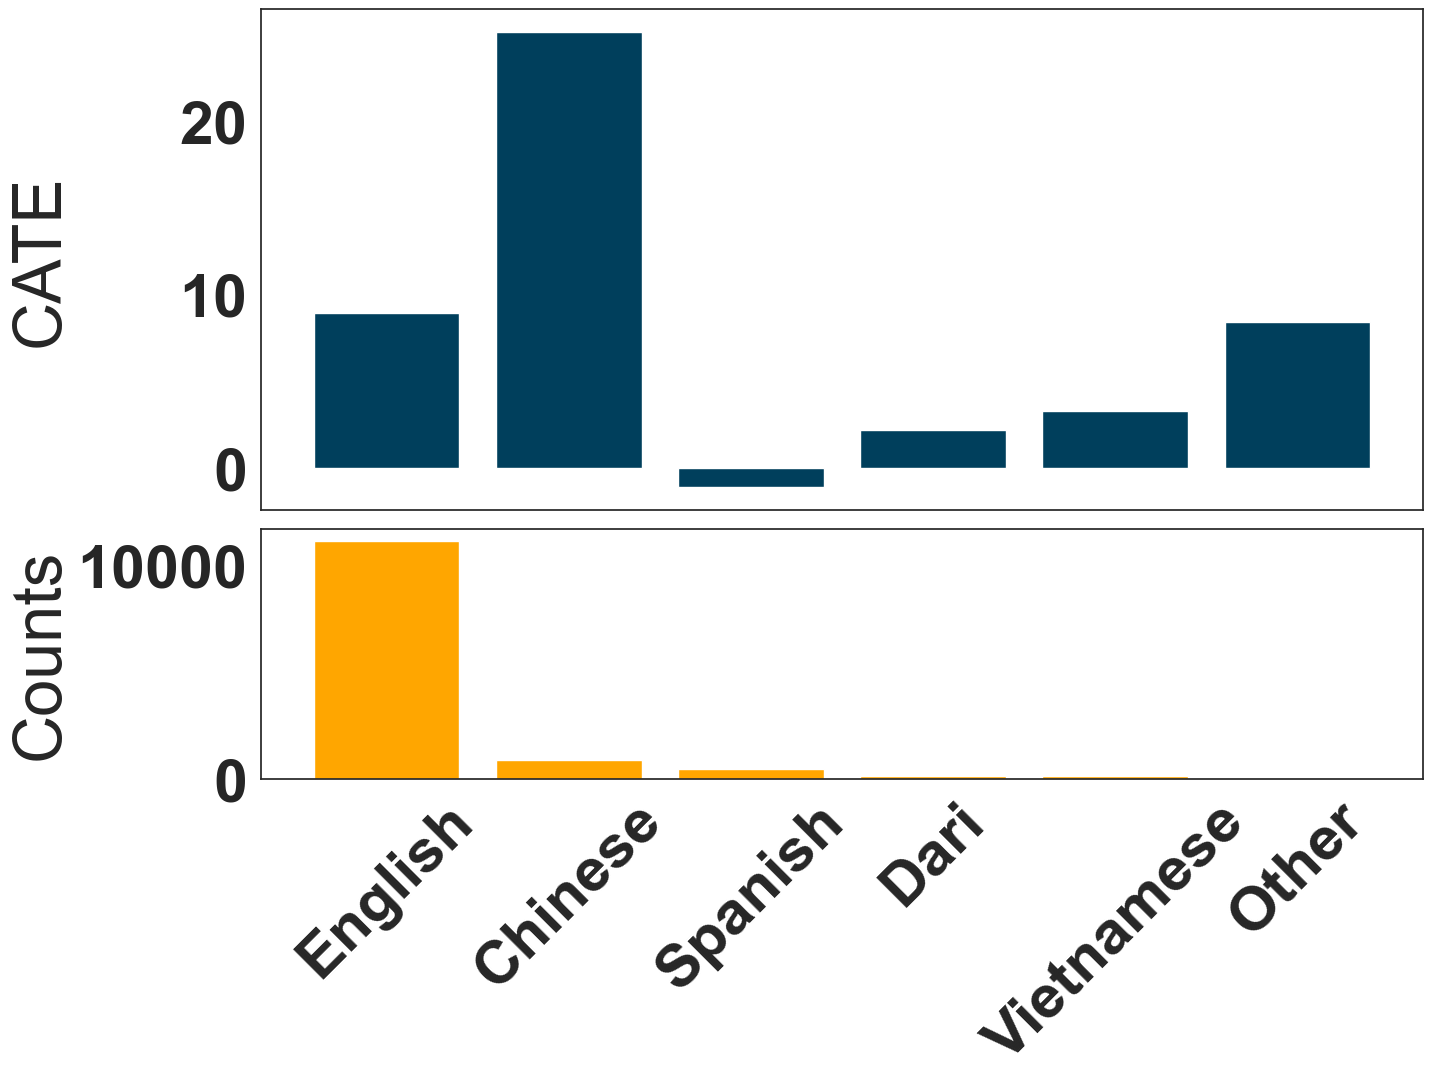

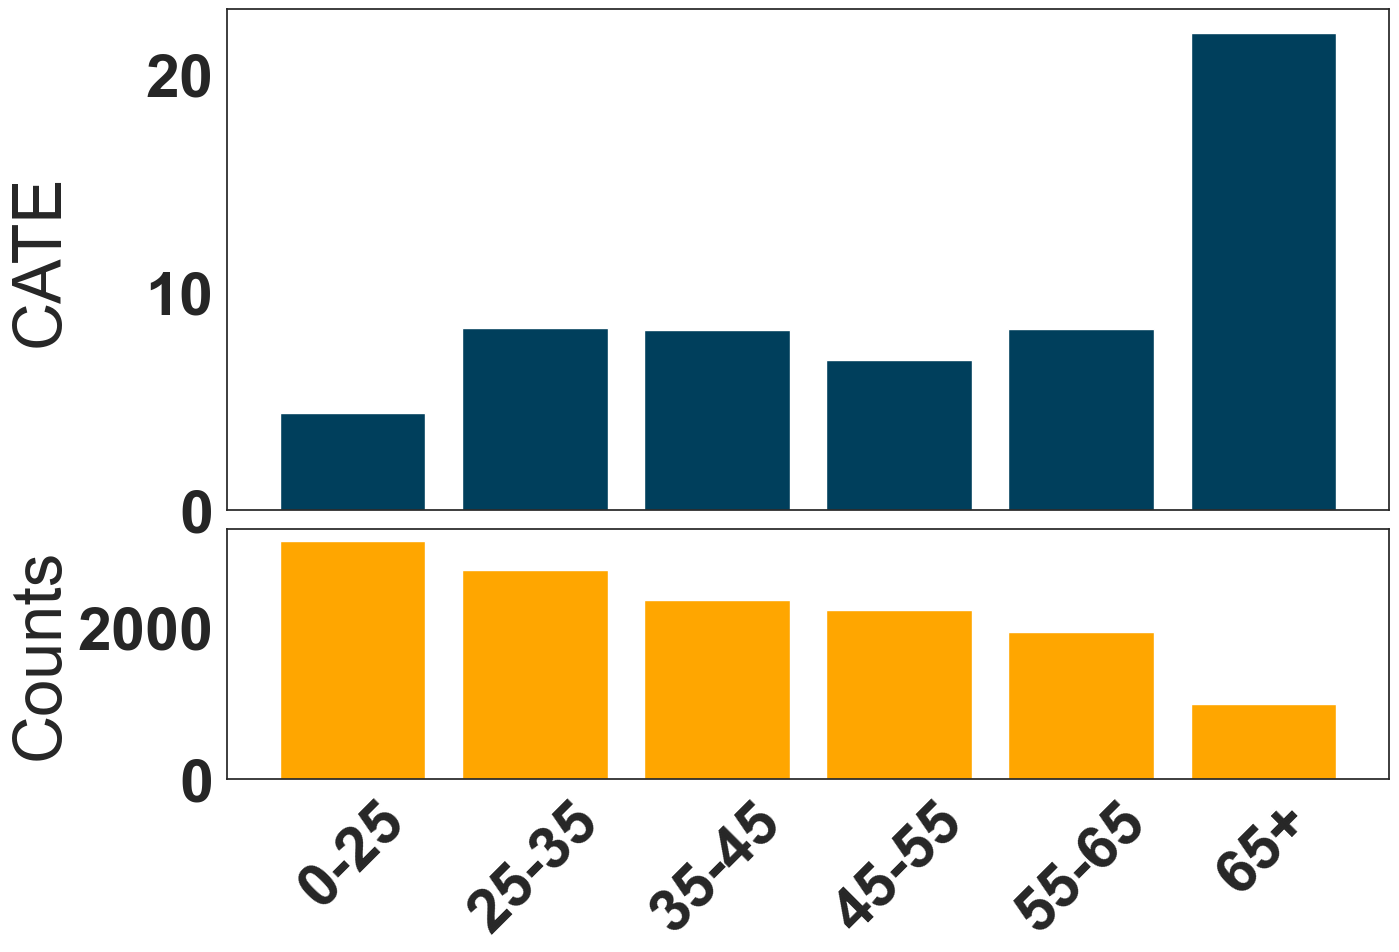

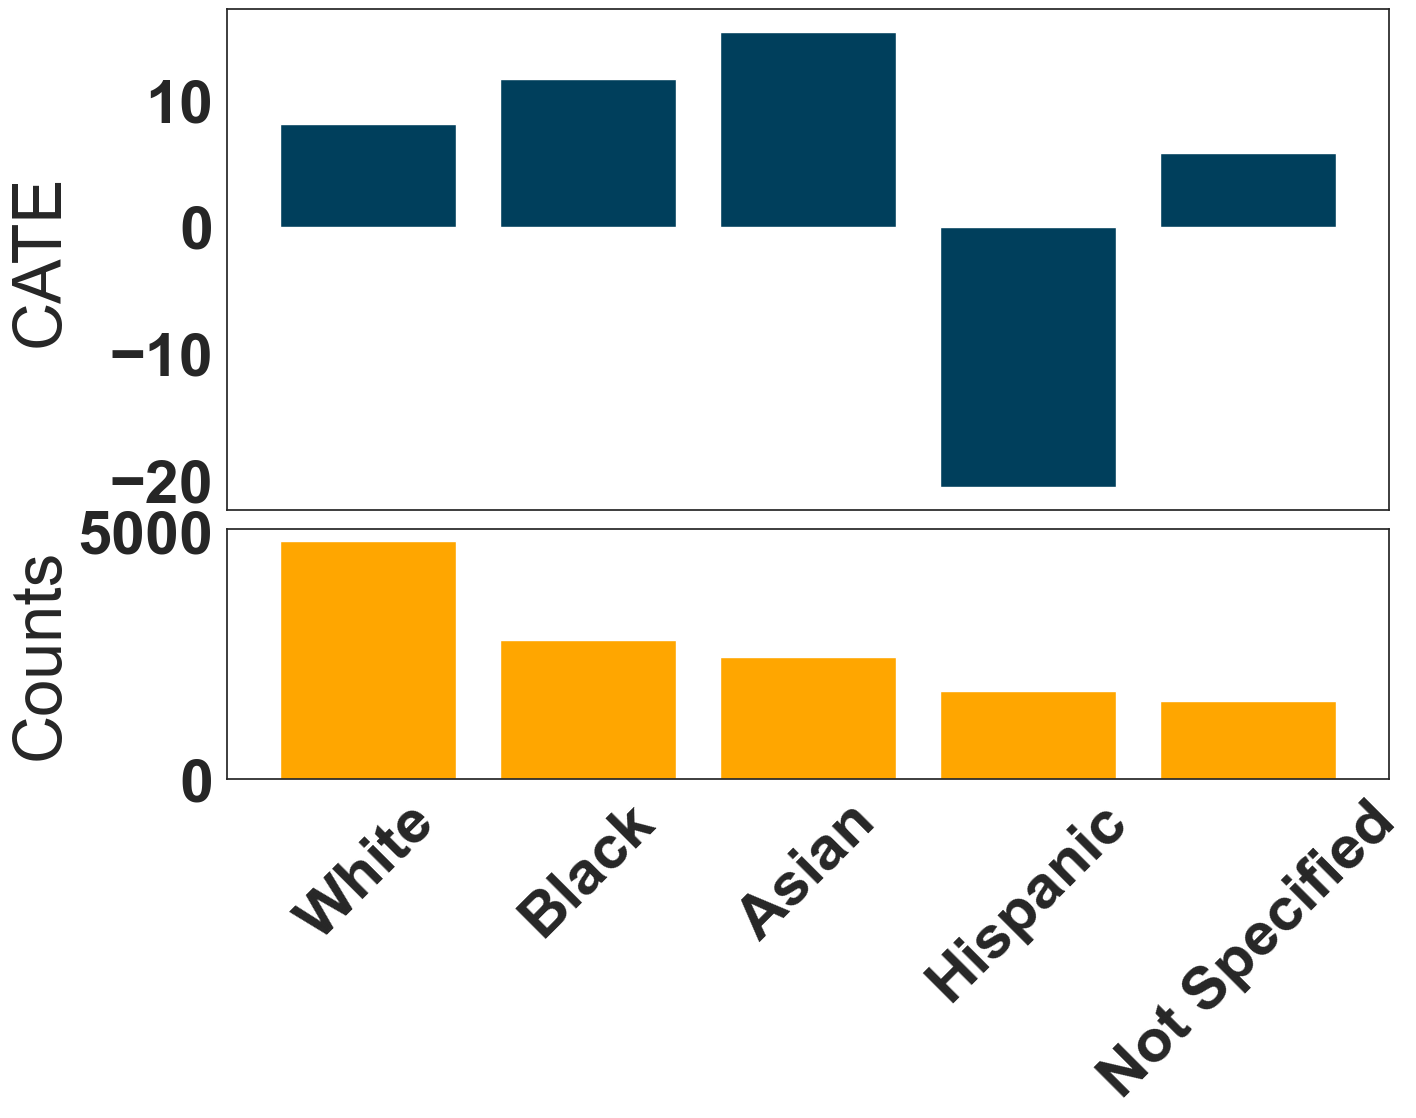

In [105]:
col = ['OverallJobAccess_quantileNum_4q','lowwagelaborforce_quantileNum_4q','Access30Transit_quantileNum_4q',
        'Access30Transit_ts_quantileNum_4q','spatialmismatch_quantileNum_4q',
        'Agency','Language','Age_bin','RaceDesc']
plot_column_CATE(covariates = col,dataframe=df_dic_ridership, response = 'ridership')